# **Predicting the Quality of White Portuguese Vinho Verde wine**

# **PACE stages**
Throughout this project, you'll see references to the problem-solving framework, PACE. This notebook components are labeled with the respective PACE stages: Plan, Analyze, Construct, and Execute. 

# **Pace: Plan Stage**

## Business Understanding

In Portugal's wine industry, a crucial aspect of quality assurance is the certification and evaluation of wines. During the certification phase, analytical tests are utilized to measure the physicochemical components of the wine, and the wine quality is evaluated using sensory analysis by a panel of experts. This project aims to develop a machine learning model to predict wine quality based on objective analytical test results with the goal of reducing the inherent subjectivity present in human sensory analysis. 

### Goal and Deliverables

**Goal:** Analyze the provided dataset and build predictive models that can offer insights to CVRVV (The Viticulture Commission of the Vinho Verde Region), a wine certification agency, to gain a deeper understanding of factors that affect wine quality and to aid wine experts during sensory analysis. 

**Deliverables:**
1. One-page executive summary that would be presented to external stakeholders.
2. Complete code python notebook

### Scope and Limitation
Due to the constraint of data imbalance, the classes of wine that will be predicted in this modeling effort are the following: 
1. **low** (quality score of 0-4)
2. **medium** (quality score of 5-6)
3. **high** (quality score of 7-10)

## Data Understanding
The dataset was taken from [University of California Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/186/wine+quality). Each entry in the dataset is the result of a given test (analytical or sensory). The type of wine represented in this dataset is the white variant of the  Portuguese "Vinho Verde" wine.

It contains 4,898 rows&mdash;each representing all test results of a unique white wine sample. It has 12 columns which are listed below: 

  Variable  |Description |
-----|-----|
fixed_acidity|Most acids involved with wine are fixed or nonvolatile (*do not evaporate easily*) [3.8&ndash;15.9]|
volatile_acidity|The amount of acetic acid in wine, which at too high of levels can lead to an unpleasant vinegar taste [0.1&ndash;1.6]|
citric_acid|Found in small quantities, citric acid can add 'freshness' and flavor to wines [0.0&ndash;1.7]|
residual sugar|The amount of sugar remaining after fermentation stops [0.6&ndash;65.8]|
chlorides|The amount of salt in the wine [0.01&ndash;0.61]|
free_sulfur_dioxide|The free form of SO2 exists in equilibrium between molecular SO2 (*as a dissolved gas*) and bisulfite ion [1&ndash;289]|
total_sulfur_dioxide|Amount of free and bound forms of sulfur dioxide gas (SO2) [6&ndash;440]|
density|[0.987&ndash;1.039]|
pH|Describes how acidic or basic a wine is [2.7&ndash;4.0]|
sulphates|A wine additive which can contribute to sulfur dioxide gas (SO2) levels, which acts as an antimicrobial and antioxidant [0.2&ndash;2.0]|
alcohol|[8.0&ndash;14.9]|
quality|Based on sensory data [0&ndash;10]|


**Note:** The wine samples came from different manufacturers from the northwest region of Portugal and were tested at the official certification entity called CVRVV. Therefore, expect different range of results for each given test. 

## Step 1. Imports

In [1]:
# Import packages for data manipulation
import numpy as np
import pandas as pd

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# Import packages for data modeling
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
f1_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

# Import the modeling algorithm to be used
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# To address the class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

# PCA
from sklearn.decomposition import PCA


# To save the fitted models
import pickle

# For nested cross-validation
from sklearn.model_selection import StratifiedKFold, cross_validate

In [2]:
# load dataset
df0 = pd.read_csv('winequality-white.csv', sep=';')
df0.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## Step 2. Data Exploration
* Understand variables
* Clean the dataset (remove duplicates)

### Gather basic information about the data

In [3]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


### Rename columns

In [4]:
# Rename columns
df0.rename(columns={'fixed acidity': 'fixed_acidity',
                    'volatile acidity': 'volatile_acidity',
                    'citric acid': 'citric_acid',
                    'residual sugar': 'residual_sugar',
                    'free sulfur dioxide': 'free_sulfur_dioxide',
                    'total sulfur dioxide': 'total_sulfur_dioxide'}, inplace=True)

# Diplay the column names after the updata
df0.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

### Gather descriptive statistics about the data

In [5]:
df0.describe(include='all')

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


### Check missing values

In [6]:
df0.isna().any(axis=0).sum()

0

* There are no missing values in the dataset. 

### Check duplicates

In [7]:
# Check for duplicates
df0.duplicated().sum()

937

In [8]:
# Inspect the duplicated rows of all columns
df0[df0.duplicated(keep=False)]

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.800000,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.500000,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.100000,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.900000,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.900000,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4851,6.4,0.33,0.44,8.9,0.055,52.0,164.0,0.99488,3.10,0.48,9.600000,5
4855,7.1,0.23,0.39,13.7,0.058,26.0,172.0,0.99755,2.90,0.46,9.000000,6
4856,7.1,0.23,0.39,13.7,0.058,26.0,172.0,0.99755,2.90,0.46,9.000000,6
4879,6.6,0.34,0.40,8.1,0.046,68.0,170.0,0.99494,3.15,0.50,9.533333,6


* There are 937 rows of duplicated data.
* As shown in the table above (*look at the last 2 rows*), the dataset is composed of several continuous variables, the likelihood of two or more wine samples having the sample exact information in all the columns in the dataset is extremely low. So it is reasonable to drop duplicates. Also, since the assumption is that each row should represent a unique wine sample, the duplicates should be dropped to ensure reliable analysis. 

In [9]:
# Drop duplicates and save the resulting dataframe in a new variable as needed
df = df0.drop_duplicates(keep='first')

# Display the shape of the dataset
df.shape

(3961, 12)

# **pAce: Analyze Stage**
* Perform Exploratory Data Analysis (EDA) to analyze relationships between variables

### **`quality`:** Check the target variable's class distribution

* Assessed by a minimum of three sensory blind tastings, wine experts graded the wine on a scale ranging from 0 (*very poor*) to 10 (*very excellent*).

**What does the term `quality` mean?** 
* According to Hopfer et al. (2014) [^1], wine quality has a strong correlation to aroma and flavor descriptions. Also, when discussing the quality of wine, both consumers and wine experts use hedonic descriptors, which refer to pleasant and unpleasant sensations felt when drinking wine. Therefore, the `quality` in this context refers to aroma, flavor, and hedonic descriptors. 

[^1]: Hopfer, H., & Heymann, H. (2014). Judging wine quality: Do we need experts, 
consumers or trained panelists? Food Quality and Preference, 32, 221-233. 
10.1016/j.foodqual.2013.10.004

In [10]:
df['quality'].value_counts(normalize=True).sort_values(ascending=False)

quality
6    0.451401
5    0.296642
7    0.173946
4    0.038627
8    0.033072
3    0.005049
9    0.001262
Name: proportion, dtype: float64

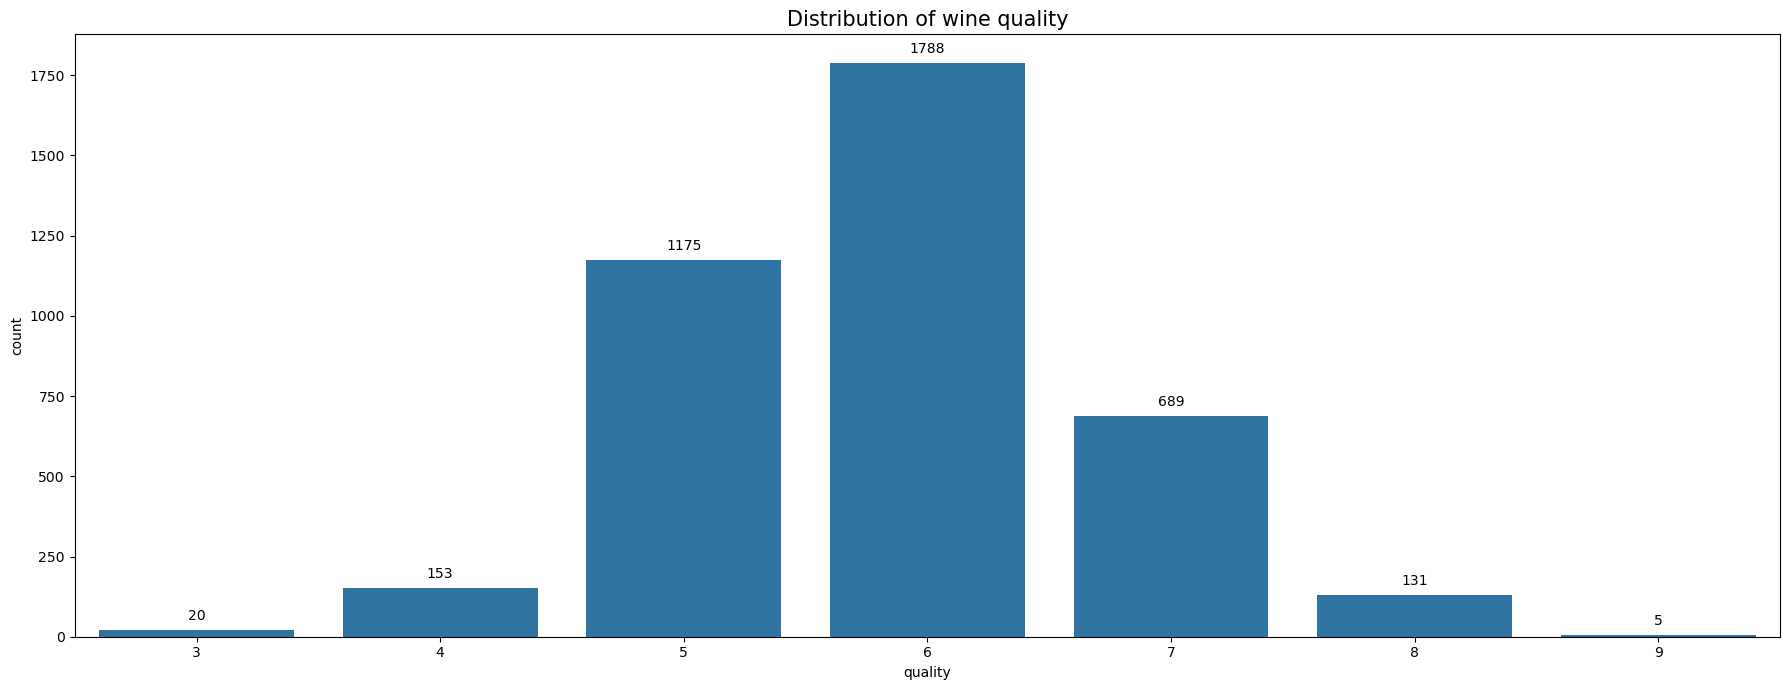

In [11]:
plt.figure(figsize=(18,7))
ax = sns.countplot(x=df['quality'])
ax.set_title('Distribution of wine quality', fontsize='15')

def add_value_labels(ax, spacing=5):
    """
    Add labels to the end of each bar.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label
        space = spacing
        
        # Vertical alignment 
        va = 'bottom'

        # Use Y value as label and format number with one decimal place
        label = '{:1.0f}'.format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords='offset points', # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(ax)
plt.tight_layout()
plt.show()

#### Making new multi-class classification for the target variable
* Divide the wine dataset into poor, medium, high
    1. `low`: quality of `0-4`
    2. `medium`: quality of `5-6` 
    3. `high`: quality of `7-10`

In [12]:
df = df.copy()              
bins = [0, 5, 7, 11]                
class_names = ['low', 'medium', 'high']
df['quality_cat']= pd.cut(df['quality'], bins = bins, labels=class_names,     
                            include_lowest=True, right=False)      

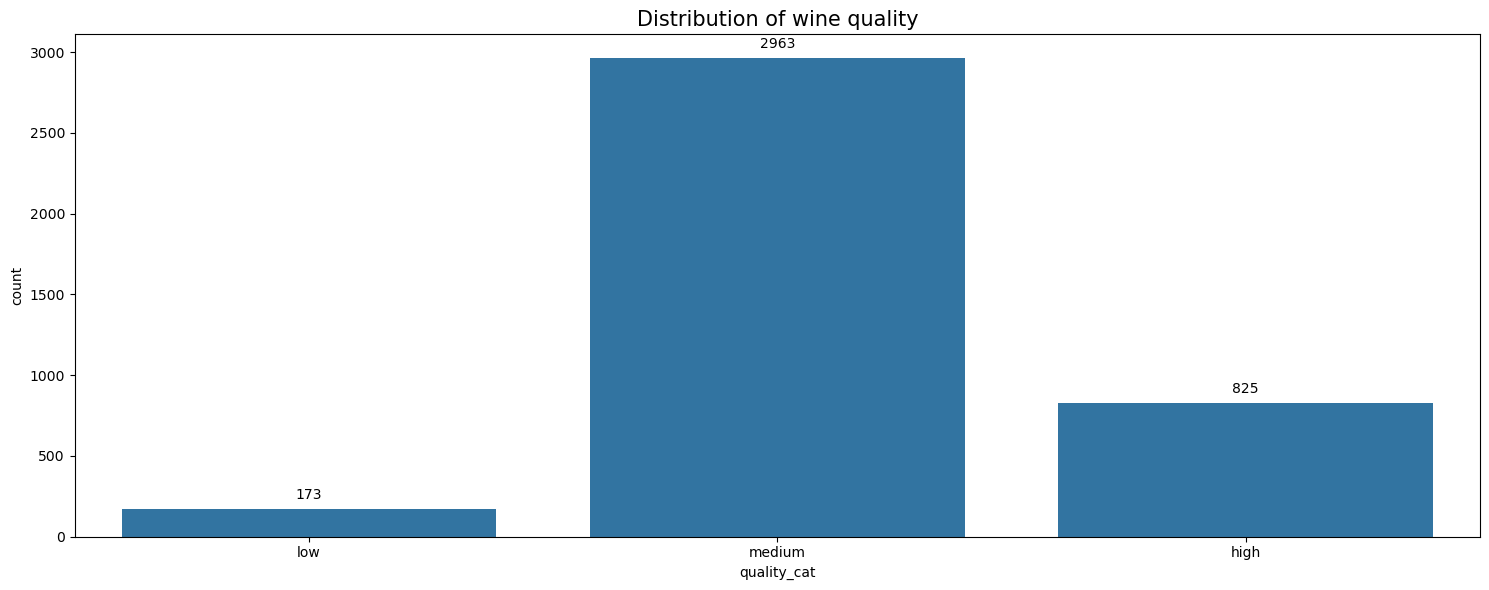

In [13]:
plt.figure(figsize=(15,6))
ax = sns.countplot(x=df['quality_cat'])
ax.set_title('Distribution of wine quality', fontsize='15')

add_value_labels(ax)
plt.tight_layout()
plt.show()

* The classes in the `quality` column are ordered and imbalanced. There are more medium-quality wines than low and high-quality wines. For instance, the wine with a quality of 6 comprises most of the dataset, about 45.14% (1788 out of 3,961 wine samples).

* There are few highly-quality wines (*with quality of 7 to 9*) and even fewer low-quality wines (*with quality of 3 and 4*)

### Check the distribution of independent variables

In [14]:
# Helper function for boxplots and histograms
def distribution_plotter(column_str, median_text=True, **kwargs):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    sns.boxplot(x=df[column_str], ax=axes[0])
    axes[0].set_title(f'{column_str} boxplot')

    median = round(df[column_str].median(),2)
    sns.histplot(x=df[column_str], **kwargs, ax=axes[1])
    plt.axvline(x=median, color='red', linestyle='--')
    if median_text == True: 
        axes[1].text(0.25, 0.85, f'median={median}', color='red',
                    ha='left', va='top', transform=axes[1].transAxes)
    else: 
        print(f'Median: {median}')
    axes[1].set_title(f'{column_str} histogram')

    plt.tight_layout()
    plt.show()

In [15]:
def empirical_verifier(column_str):
    '''
    Verify if the data follows a normal distribution. 
    Input: column in string format
    Output: Percentage distribution of data
    
        Empirical rule 1: 1STD has 68% of the data
        Empirical rule 2: 2STD has 95% of the data
        Empirical rule 3: 3STD has 99.7% of the data
    '''
    mean = df[column_str].mean()
    std = df[column_str].std()
    i = 1
    while i < 4: 
        lower_limit = mean - (i*std)
        upper_limit = mean + (i*std)
        percent_sd = ((df[column_str]>=lower_limit) & (df[column_str] <= upper_limit)).mean()
        print(f'{i}SD: {percent_sd:1.2%}')
        i += 1

#### **`fixed_acidity`:** $g(tartaric$ $acid)$ / $dm^3$ 
Most acids involved with wine are fixed or nonvolatile (*do not evaporate easily*)

In [16]:
df['fixed_acidity'].describe()

count    3961.000000
mean        6.839346
std         0.866860
min         3.800000
25%         6.300000
50%         6.800000
75%         7.300000
max        14.200000
Name: fixed_acidity, dtype: float64

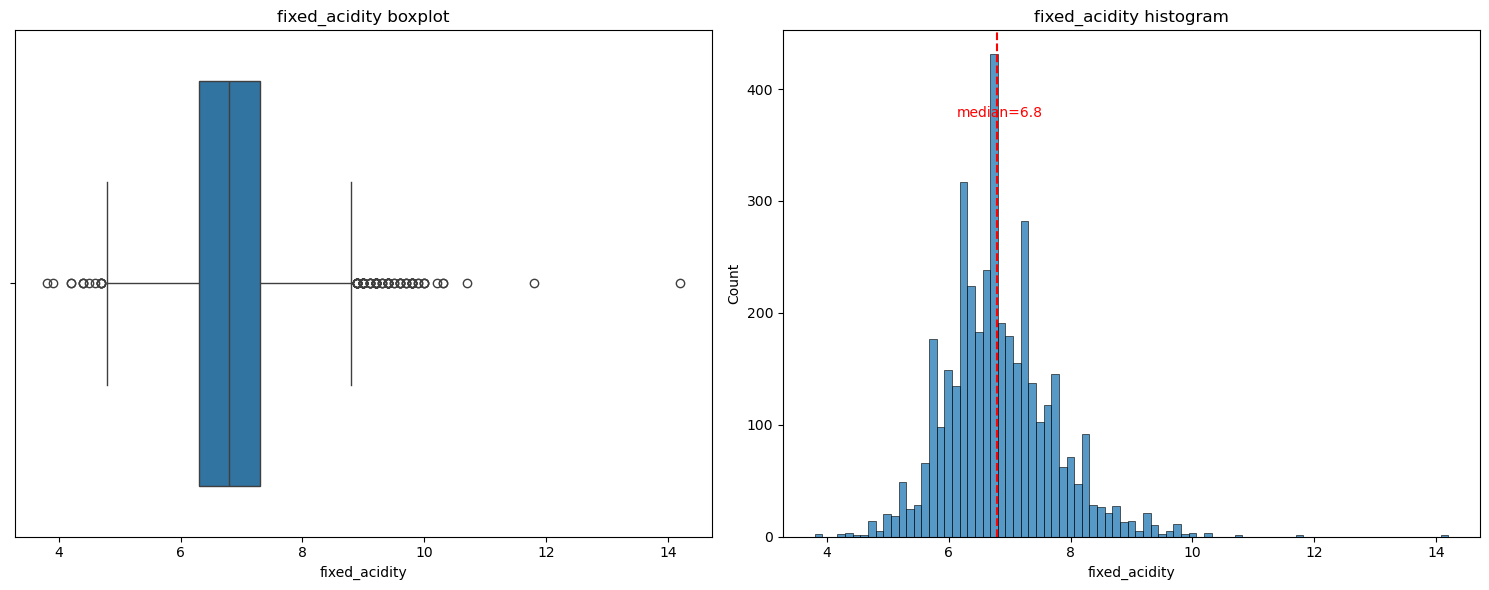

In [17]:
distribution_plotter('fixed_acidity', median_text=True)

In [18]:
empirical_verifier('fixed_acidity')

1SD: 73.57%
2SD: 94.80%
3SD: 99.17%


* From the histogram, there are more than one peak in the distribution, but the data approximately follows a normal distribution.
  
* From the boxplot, there is a presence of outliers. If models that are sensitive to outliers are to be used (i.e. logistic regression), consider imputing the outliers. 

#### **`volatile_acidity`:** $g(acetic$ $acid)$ / $dm^3$  
Responsible for the level of sourness in the wines, which at too high of levels can lead to an unpleasant vinegar taste and scent.[^2]

[^2]:  Mor, N. S. (2022). Wine quality and type prediction from physicochemical properties using neural networks for Machine Learning: A Free Software for winemakers and customers. 

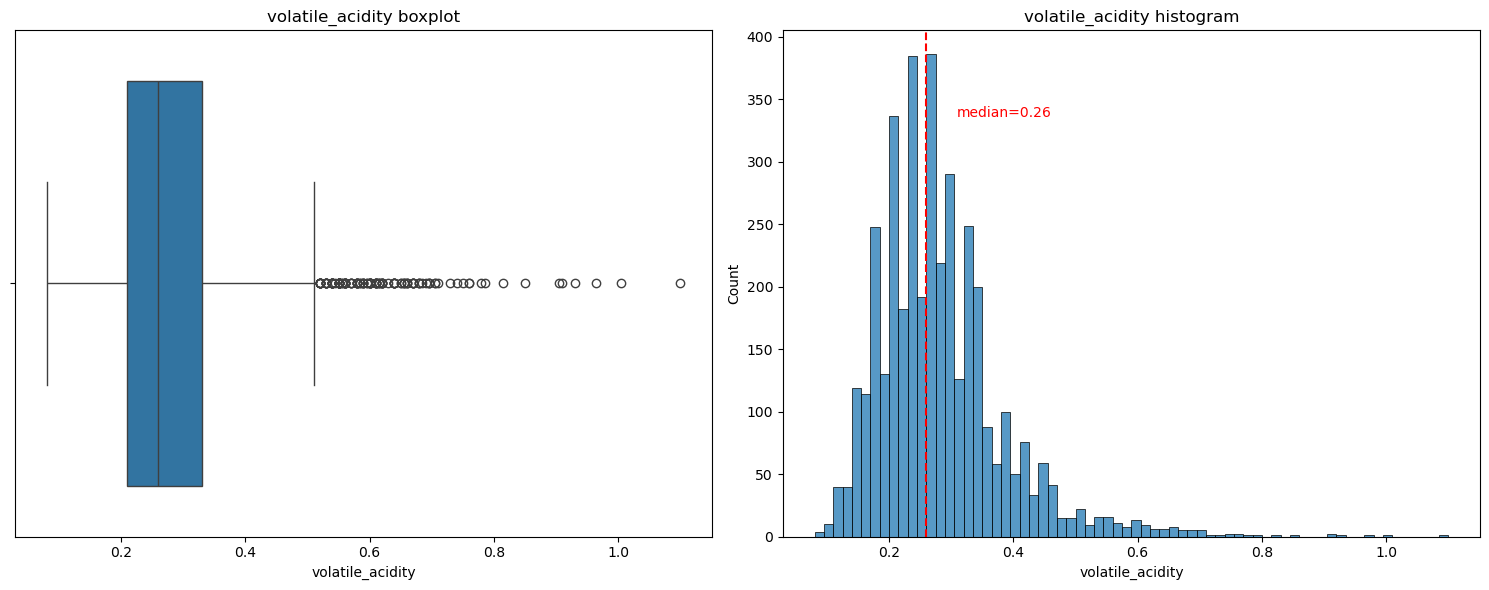

In [19]:
distribution_plotter('volatile_acidity', median_text=True)

* The distribution is right-skewed; there are more values in the left side than on the right side of the histogram.
   
* From the boxplot, there is a presence of outliers. If models that are sensitive to outliers are to be used (i.e. logistic regression), consider imputing the outliers.

#### **`citric_acid`:** $g / dm^3$  
Found in small quantities, citric acid can add 'freshness' and flavor to wines. 

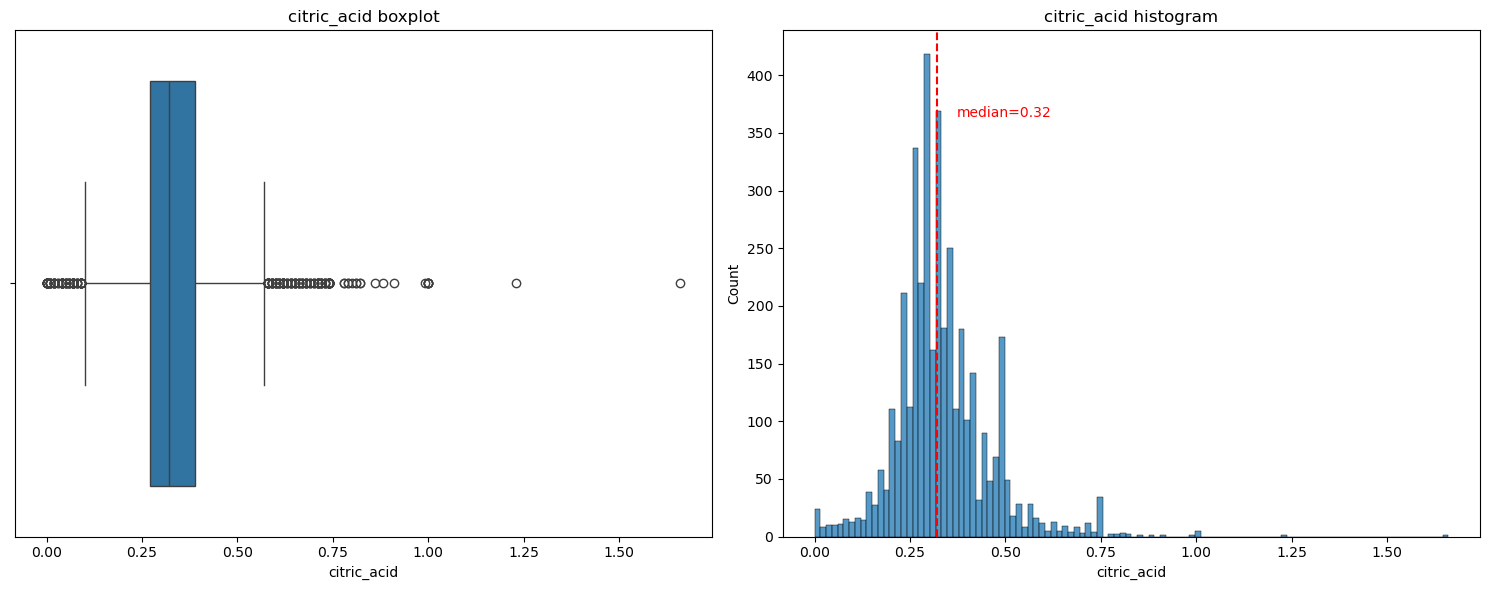

In [20]:
distribution_plotter('citric_acid', median_text=True)

In [21]:
df['citric_acid'].describe()

count    3961.000000
mean        0.334332
std         0.122446
min         0.000000
25%         0.270000
50%         0.320000
75%         0.390000
max         1.660000
Name: citric_acid, dtype: float64

* There are wine samples with 0 $g / dm^3$ of citric acid.
* There are also wine samples that have 1.0 $g / dm^3$ of citric acid, which is well above the median value of 0.32 $g / dm^3$.
* There are outliers below and above the 1.5 times the IQR (interquartile range)

#### **`residual_sugar`:** $g / dm^3$  
The amount of sugar remaining after fermentation stops.    

**Note:**   
* It is rare to find wines with less than $1$ $g / dm^3$
* Wine with greater than  $45$ $g / dm^3$ are considered sweet[^3].

[^3]: Horváth, B. O., Sárdy, D. N., Kellner, N., & Magyar, I. (2020). Effects of High Sugar 
Content on Fermentation Dynamics and Some Metabolites of Wine-Related Yeast 
Species Saccharomyces cerevisiae, S. uvarum and Starmerella bacillaris. Food 
technology and biotechnology, 58(1), 76–83.

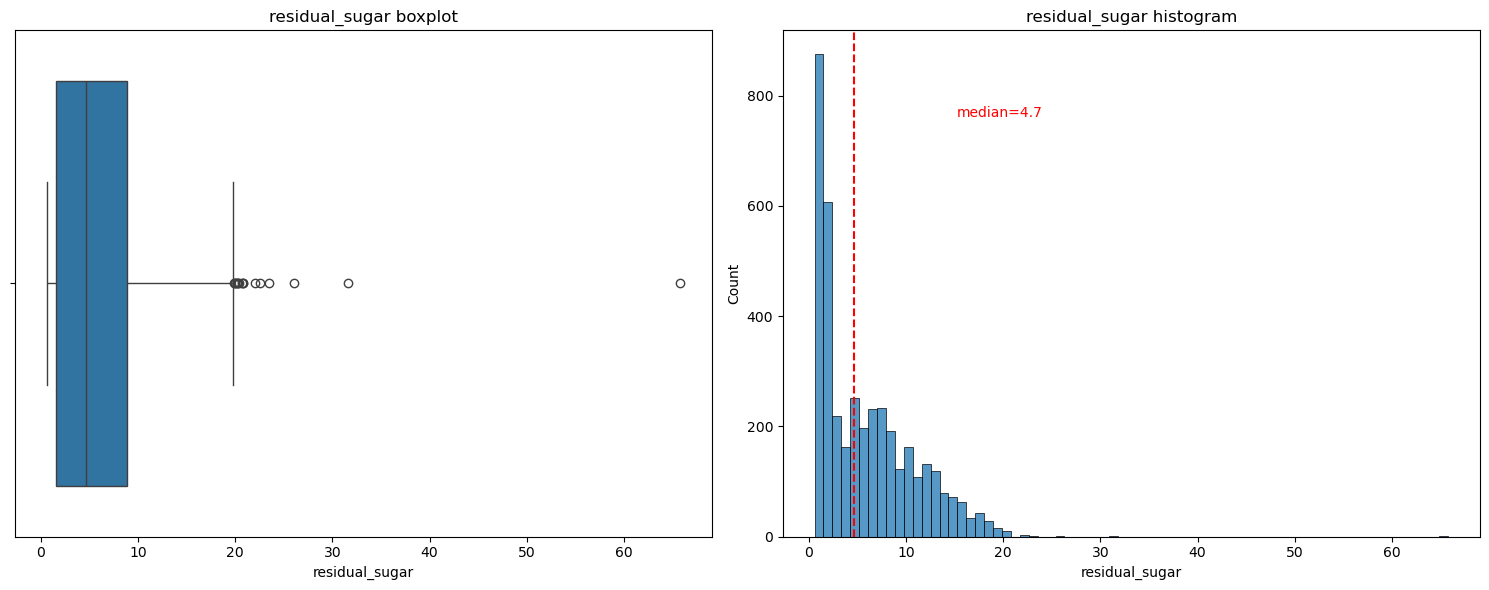

In [22]:
distribution_plotter('residual_sugar', median_text=True)

In [23]:
df['residual_sugar'].describe()

count    3961.000000
mean        5.914819
std         4.861646
min         0.600000
25%         1.600000
50%         4.700000
75%         8.900000
max        65.800000
Name: residual_sugar, dtype: float64

* The distribution is right-skewed; most sample of wine has a residual sugar content of less than 10. 

#### **`chlorides`:** $g(sodium$ $chloride)$ / $dm^3$
The amount of salt in the wine. 

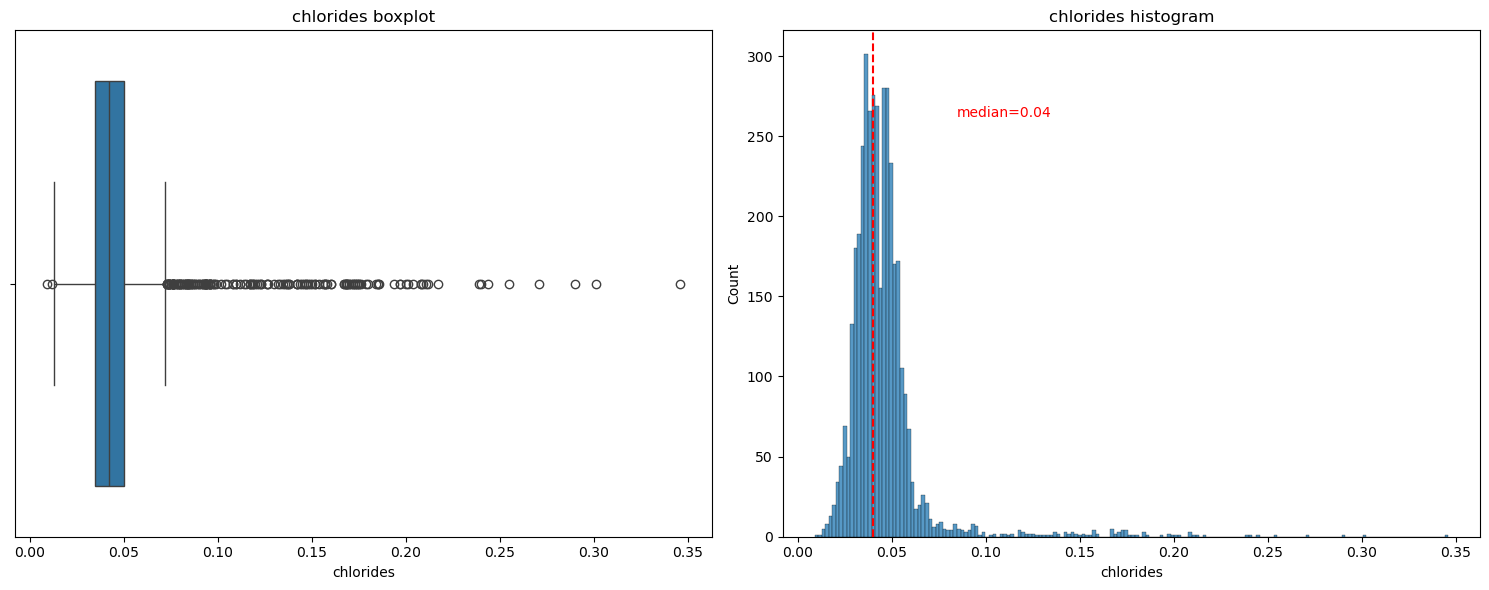

In [24]:
distribution_plotter('chlorides', median_text=True)

* The distribution is right-skewed; most sample of wine has a `chlorides` content of less than 0.1.

#### **`free_sulfur_dioxide`:** $mg / dm^3$
The free form of sulfur dioxide ($SO_2$) exists in equilibrium between molecular $SO_2$ (a dissolved gas) and bisulfite ion, which is in turn in equilibrim with sulfite ion. These equilibria depend on the pH of the wine. 


* It prevents microbial growth and the oxidation of wine.
* The $SO_2$'s antimicrobial action also helps minimize volatile acidity.
* In low concentrations, $SO_2$ is mostly undetectable in wine. But at free $SO_2$ concentrations over 50 ppm (or 50 $mg / dm^3$), $SO_2$ becomes evidents in the note and taste of wine.[^4]

[^4]: Sulfites in winemaking | Madrona Wine Merchants. https://madronawinemerchants.com/wine-tips/sulfites-in-winemaking/

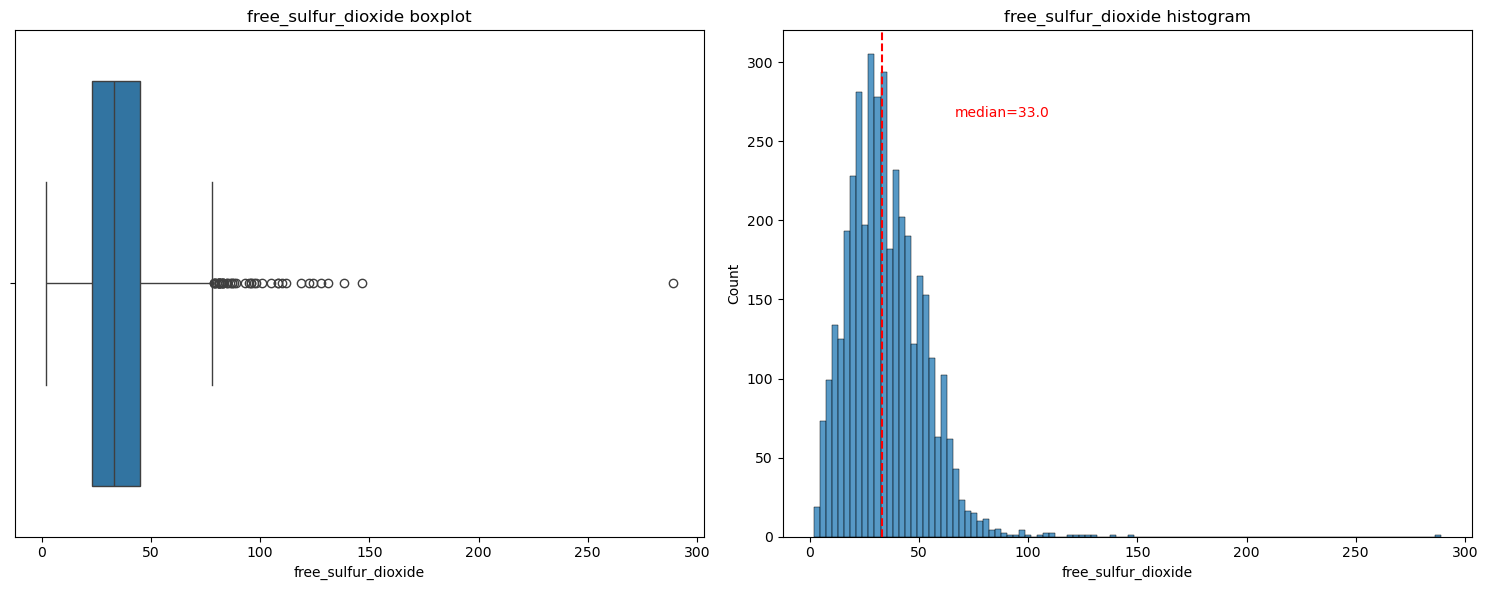

In [25]:
distribution_plotter('free_sulfur_dioxide', median_text=True)

In [26]:
df['free_sulfur_dioxide'].describe()

count    3961.000000
mean       34.889169
std        17.210021
min         2.000000
25%        23.000000
50%        33.000000
75%        45.000000
max       289.000000
Name: free_sulfur_dioxide, dtype: float64

* The distribution is right-skewed, most of the wines have free sulfur content of less than $50$ $mg / dm^3$

#### **`total_sulfur_dioxide`:** $mg / dm^3$
* The amount of free and bound forms of $SO_2$. 
* The upper limit of total SO2 allowed in the EU for white wines with residual sugar of 5 g/L or more is 250 mg/L (250 $mg / dm^3$). [^5]

[^5]: OIV - International Organisation of Vine and Wine . (2021, March). OIV Collective Expertise Document SO2 and wine: A Review . Paris, France. 

Median: 133.0


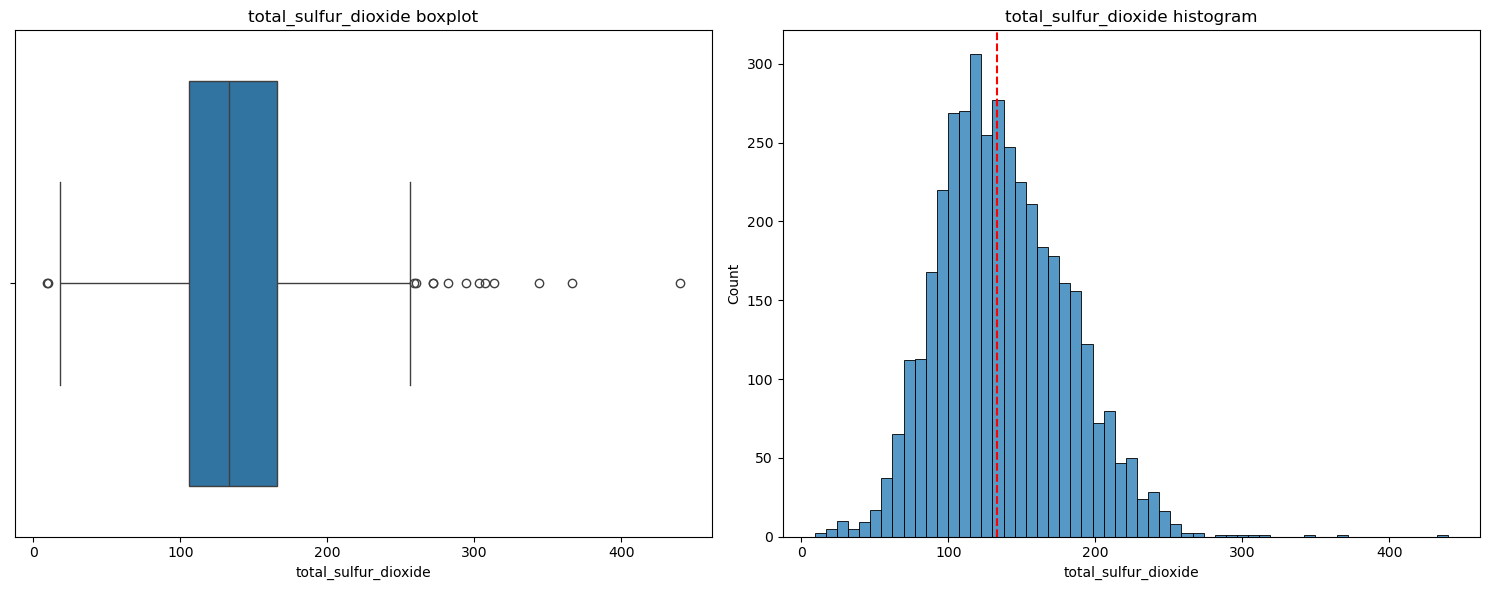

In [27]:
distribution_plotter('total_sulfur_dioxide', median_text=False)

In [28]:
wines_greater_250_SO2 = df[df['total_sulfur_dioxide']>250]
wines_greater_250_SO2.shape

(20, 13)

* Based on the histogram and the empirical rule, the `total_sulfur_dioxide` column follows an approximately normal distribution.
* There are 20 wine samples that have total_sulfur_dioxide content of more than 250 $mg / dm^3$. 

#### **`density`:** $g / cm^3$
* The density of wine is close to that of that of water. 
* Note: Some wines are meant to be denser than others; and wines such as Vinho Verde are not meant to be dense.

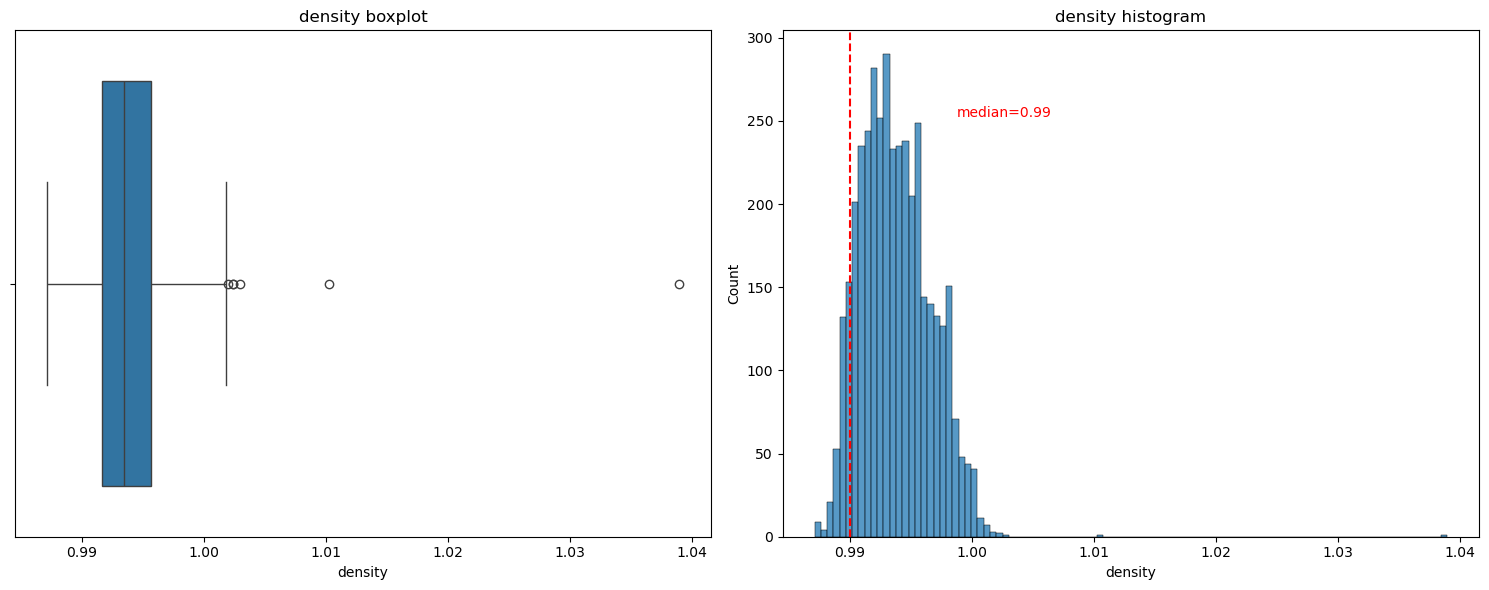

In [29]:
distribution_plotter('density', median_text=True)

In [30]:
empirical_verifier('density')

1SD: 66.47%
2SD: 97.22%
3SD: 99.92%


* Approximately normal distribution

* Present of few outliers with density value of greater than 1

#### **`pH`:**
Describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic). 
* Most wines are between 3-4 on the pH scale.
* The effectiveness of SO2 against microorganisms depends on pH. [^4]

[^4]: Sulfites in winemaking | Madrona Wine Merchants. https://madronawinemerchants.com/wine-tips/sulfites-in-winemaking/

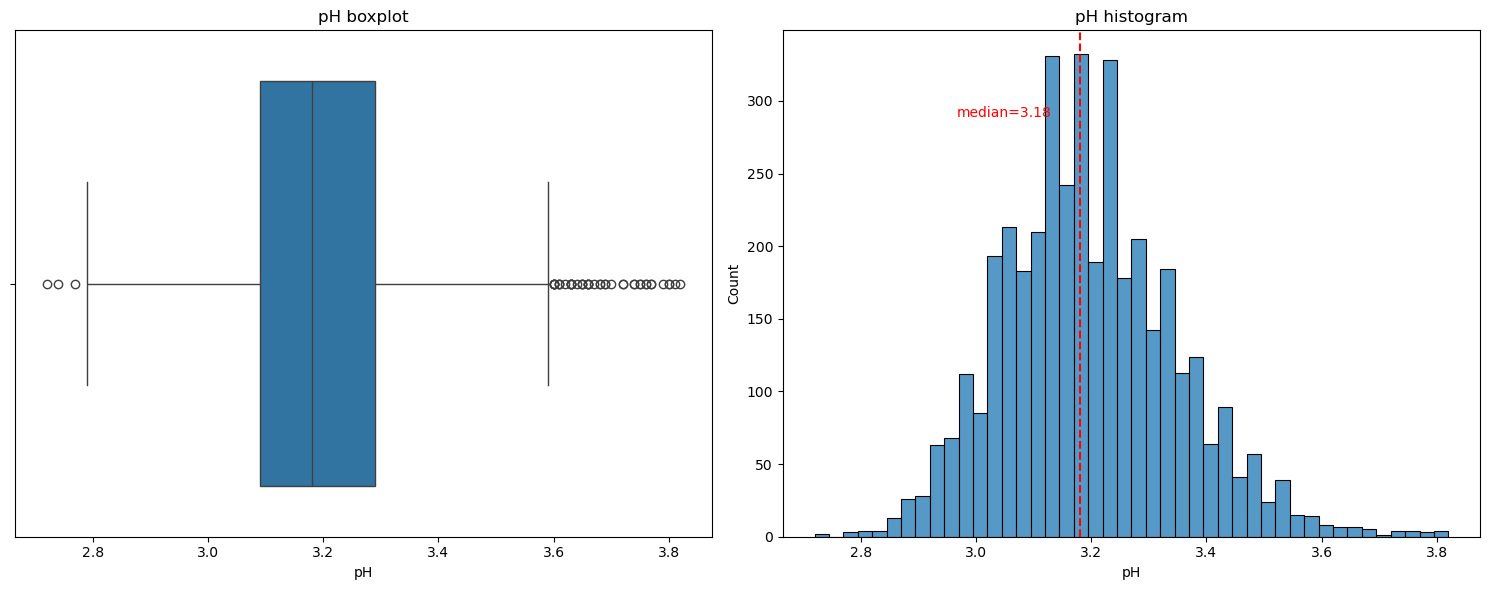

In [31]:
distribution_plotter('pH', median_text=True)

In [32]:
empirical_verifier('pH')

1SD: 69.10%
2SD: 95.28%
3SD: 99.32%


* Closely follows a normal distribution

* There is a presence of outliers below and above the 1.5 times of the Inter Quartile Range

#### **`sulphates`:** $g (potassium$ $sulphate$) / $dm^3$
A wine additive that can contribute to sulfur dioxide gas levels, which acts as an antimicrobial and antioxidant. 

Median: 0.48


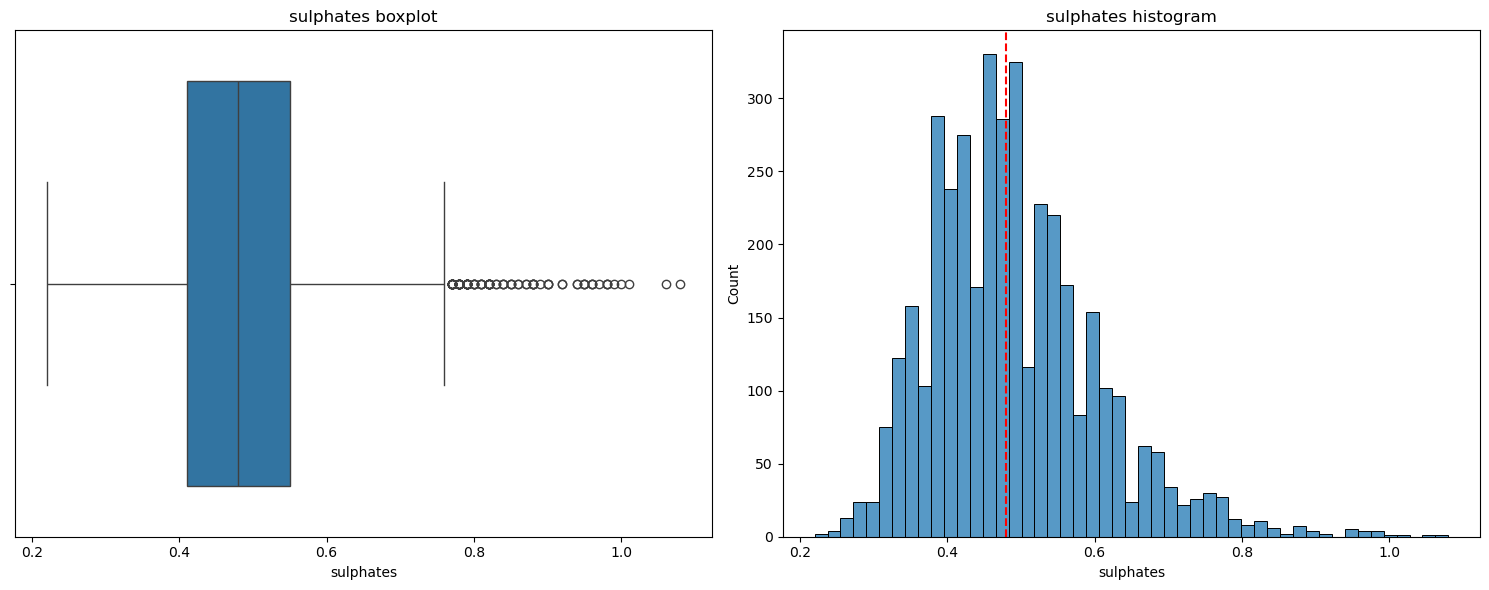

In [33]:
distribution_plotter('sulphates', median_text=False)

#### **`alcohol`:** %vol.

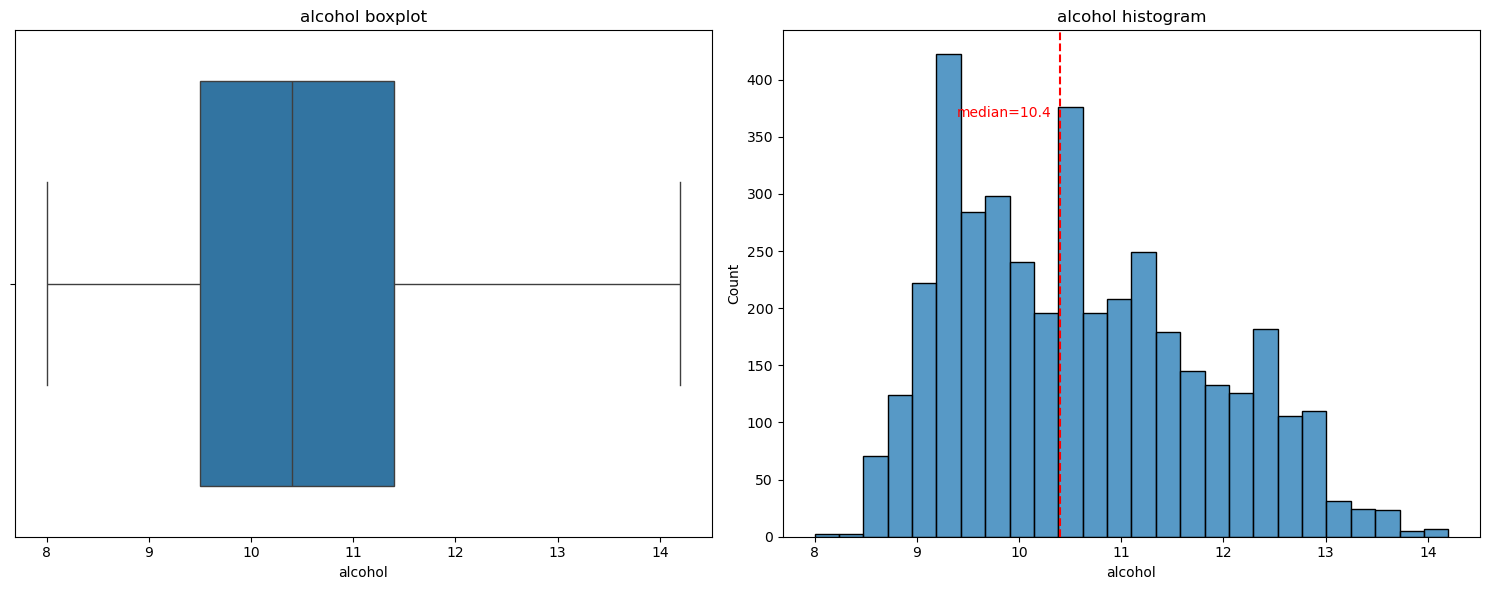

In [34]:
distribution_plotter('alcohol', median_text=True)

In [35]:
empirical_verifier('alcohol')

1SD: 64.13%
2SD: 97.68%
3SD: 100.00%


* The alcohol content of all the wine samples are within below and above the 3 times standard deviation. 

### Check the relationship between variables

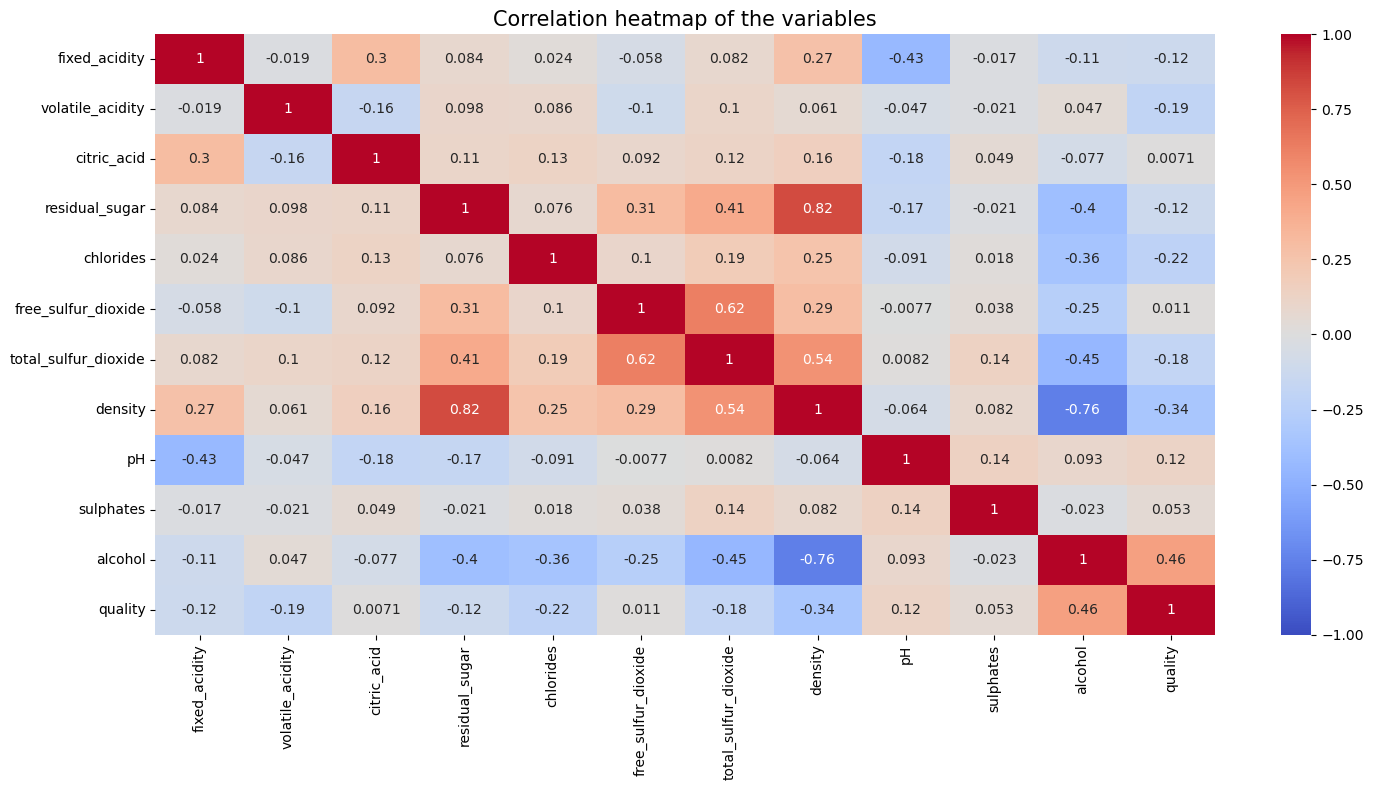

In [36]:
# Correlation heatmap 
plt.figure(figsize=(15,8))
fig = sns.heatmap(df.corr(method='pearson', numeric_only=True), vmin=-1, vmax=1,
                 annot=True, cmap='coolwarm')
fig.set_title('Correlation heatmap of the variables', fontsize='15')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

* Based on the correlation heatmap, `residual_sugar`, `density`, and `alcohol` are significantly correlated to each other. This should be considered during feature selection. 
    1. `residual_sugar` and `density` have high positive correlation (greater than 0.7)
    2. `alcohol` and `density` have high negative correlation (greater than 0.7) 
* Also, `quality` has moderate positive correlation to `alcohol` and moderate negative correlation to `density`, `chlorides`, `volatile_acidity`

In [37]:
# Outputs a boxplot of quality predictors
def quality_predictor(column_str, space):
    '''
    Arguments: 
        * column_str: column name in string format
        * space: space between the bar and the bar label
    '''
    plt.figure(figsize=(15,7))
    median = df[column_str].median()
    print(f'Broken red line (Median value): {median:1.2f}')
    ax = sns.barplot(data=df, x='quality', y=column_str, hue='quality_cat', alpha=0.4)
    plt.axhline(median, color='red', linestyle='--')
    plt.legend(bbox_to_anchor=(1,1))
    for container in ax.containers:
        ax.bar_label(container, padding=space, fmt='%.3f') 
    ax.set_title(f'{column_str} vs quality')
    plt.show();

Broken red line (Median value): 10.40


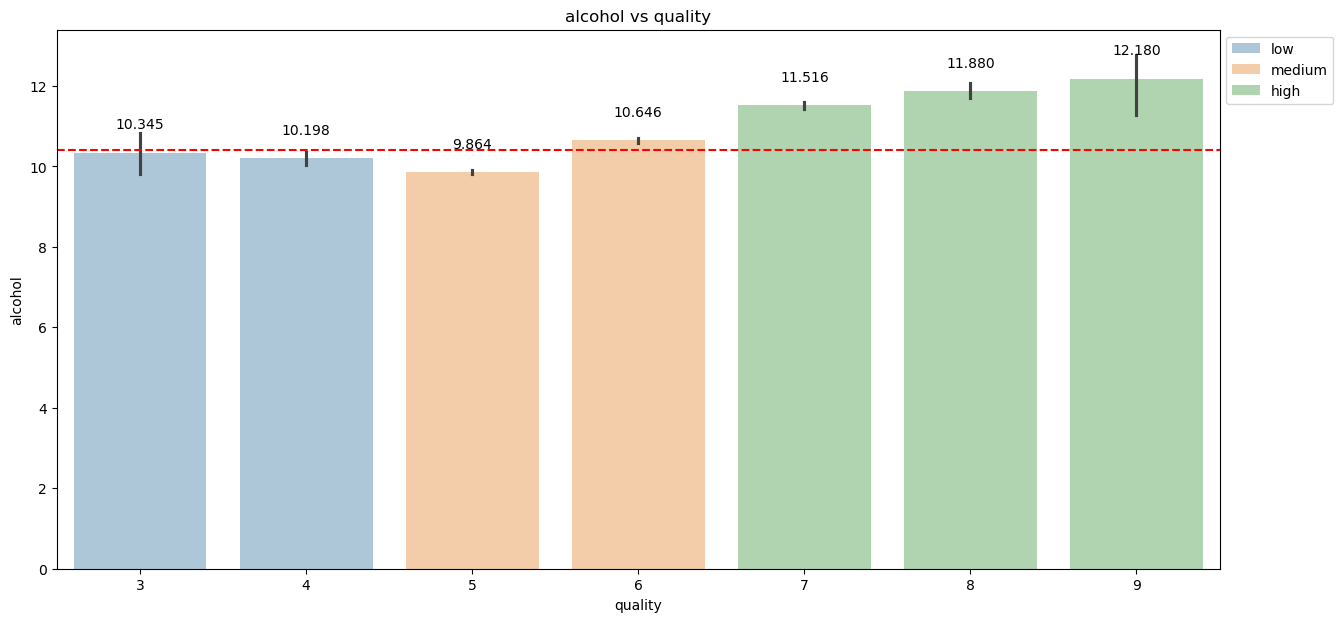

In [38]:
# quality vs alcohol
quality_predictor('alcohol', 15)

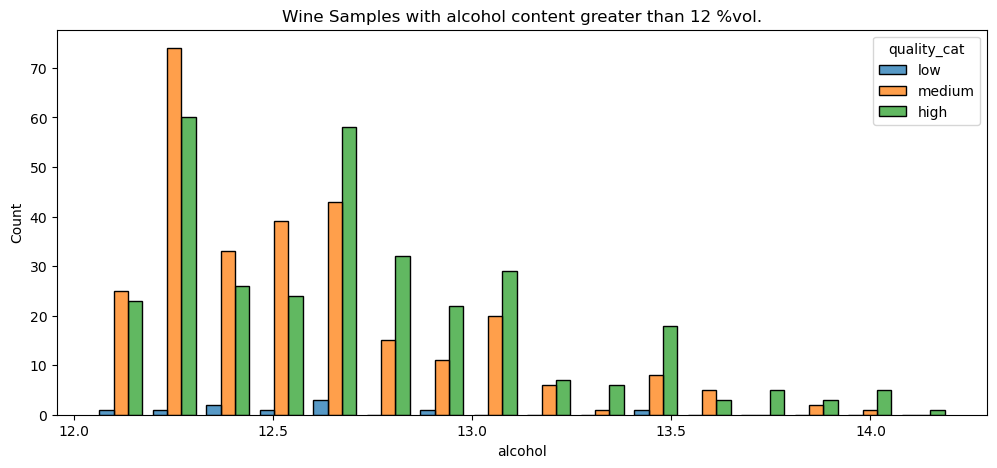

In [39]:
alcohol_greater_than_12 = df[df['alcohol']>12]
plt.figure(figsize=(12,5))
fig = sns.histplot(data=alcohol_greater_than_12, x='alcohol', 
                  hue='quality_cat',
                  multiple='dodge', shrink=.8)
fig.set_title('Wine Samples with alcohol content greater than 12 %vol.')
plt.show()

* High-quality wine seems to have higher alcohol content, in contrast, low-quality wines have lower alcohol content.
* This confirms that alcohol content is a good predictor of the quality of wine. 

Broken red line (Median value): 0.99


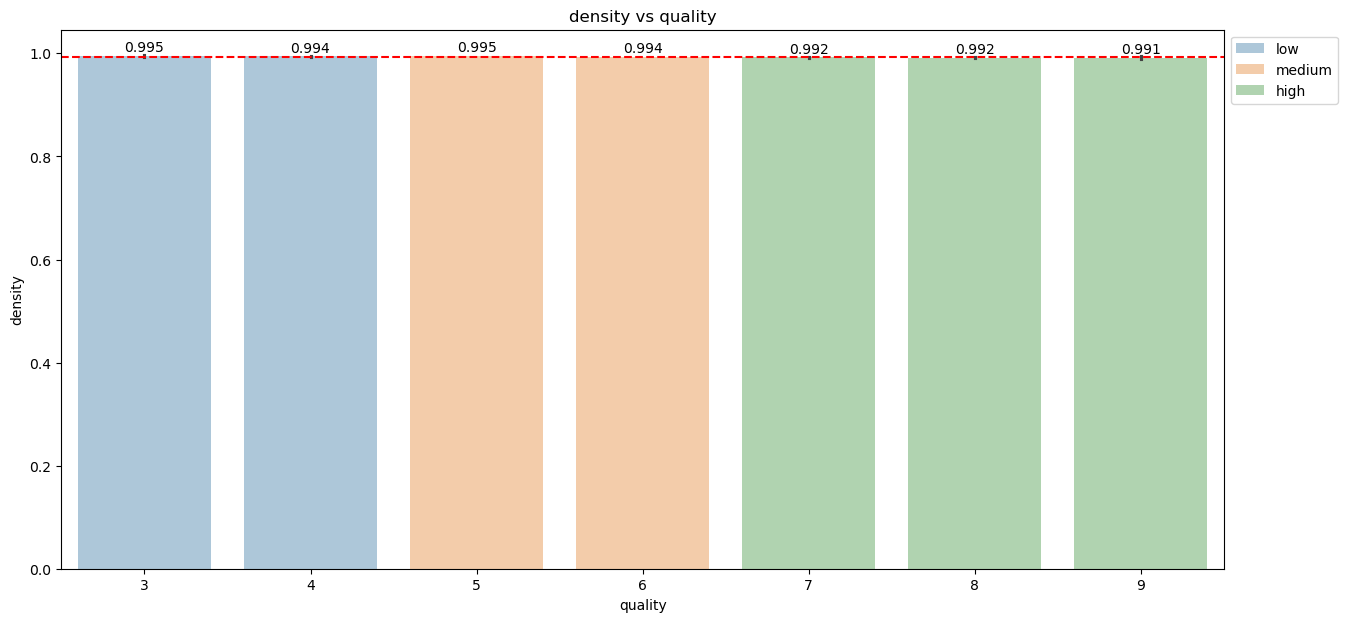

In [40]:
# quality vs density
quality_predictor('density', 1)

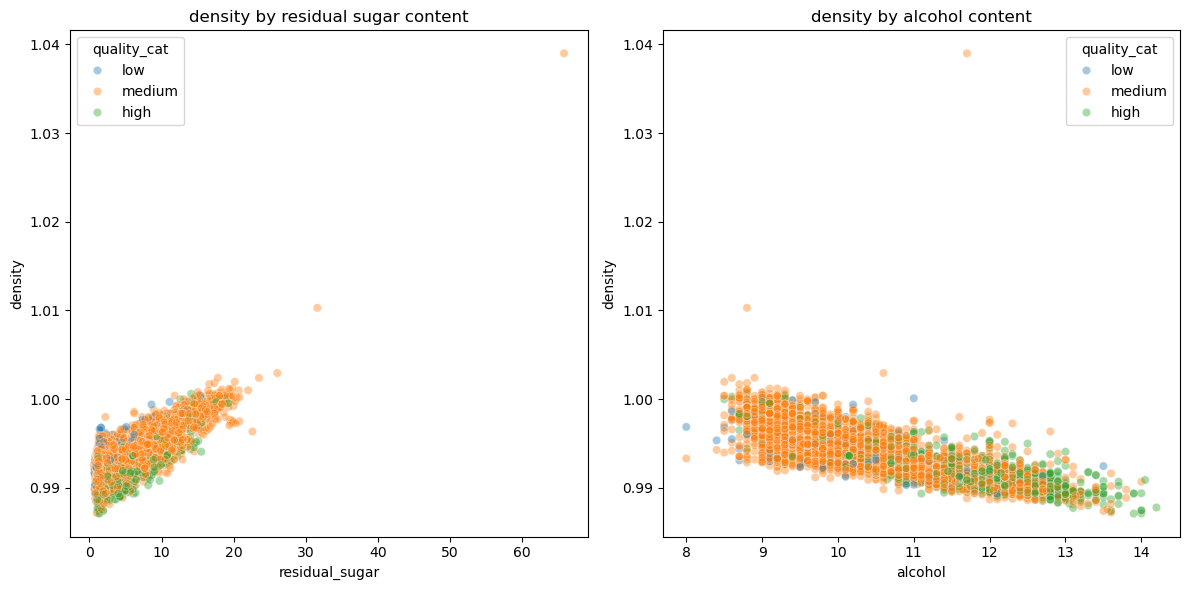

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
sns.scatterplot(data=df, x='residual_sugar', y='density', 
                hue='quality_cat', alpha=0.4, ax=axes[0])
axes[0].set_title('density by residual sugar content')

sns.scatterplot(data=df, x='alcohol', y='density', 
                hue='quality_cat',alpha=0.4, ax=axes[1])
axes[1].set_title('density by alcohol content')
plt.tight_layout()
plt.show()

* Density seems to have some correlation with residual sugar and alcohol content.

* Sweeter wines have higher density, while more alcoholic wines have lower density.

* From the scatterplots, high-quality wines (with high alcohol content) seem to have lower densities. 

Broken red line (Median value): 0.26


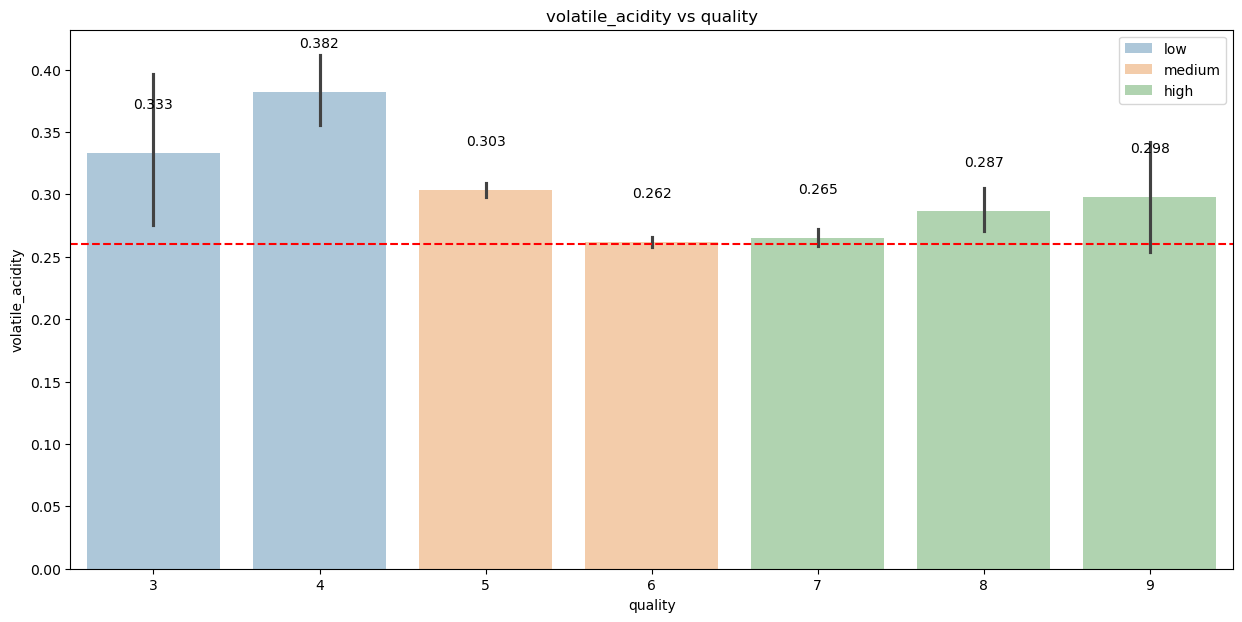

In [42]:
# quality vs volatile acidity
quality_predictor('volatile_acidity', 30)

* Low-quality wine has `volatile_acidity` value higher than the median value. This makes sense since higher levels can lead to an unpleasant vinegar taste.

Broken red line (Median value): 0.04


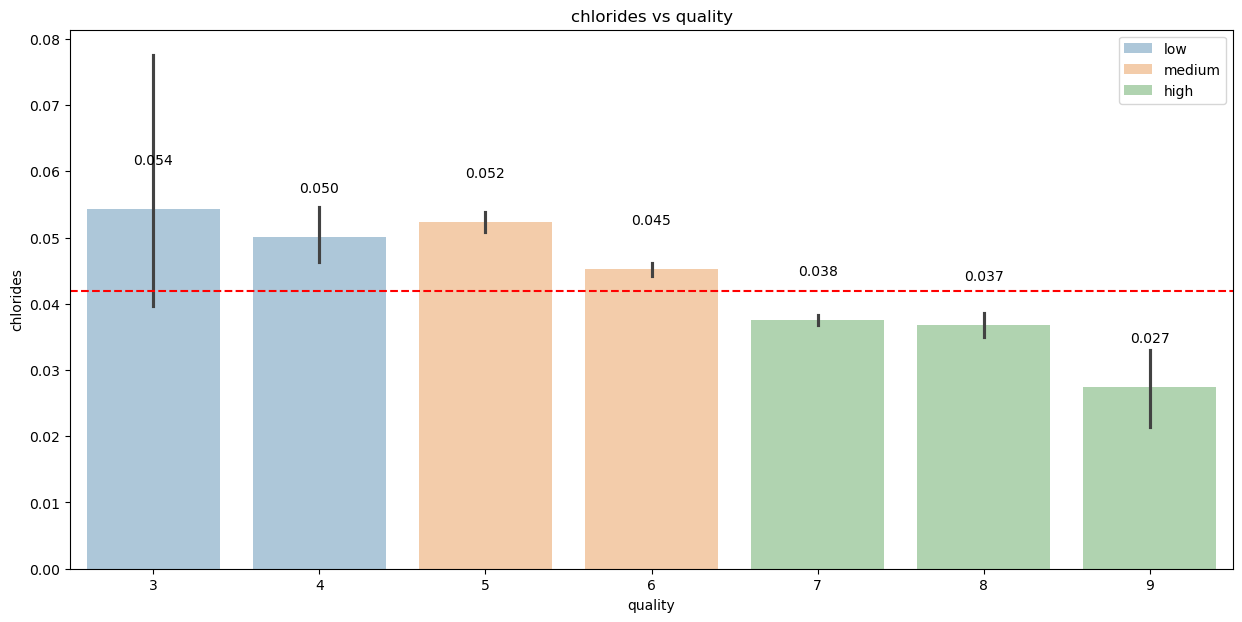

In [43]:
# chlorides vs quality
quality_predictor('chlorides', 30)

* High-quality wines have noticeably lower chlorides content. 

Broken red line (Median value): 0.32


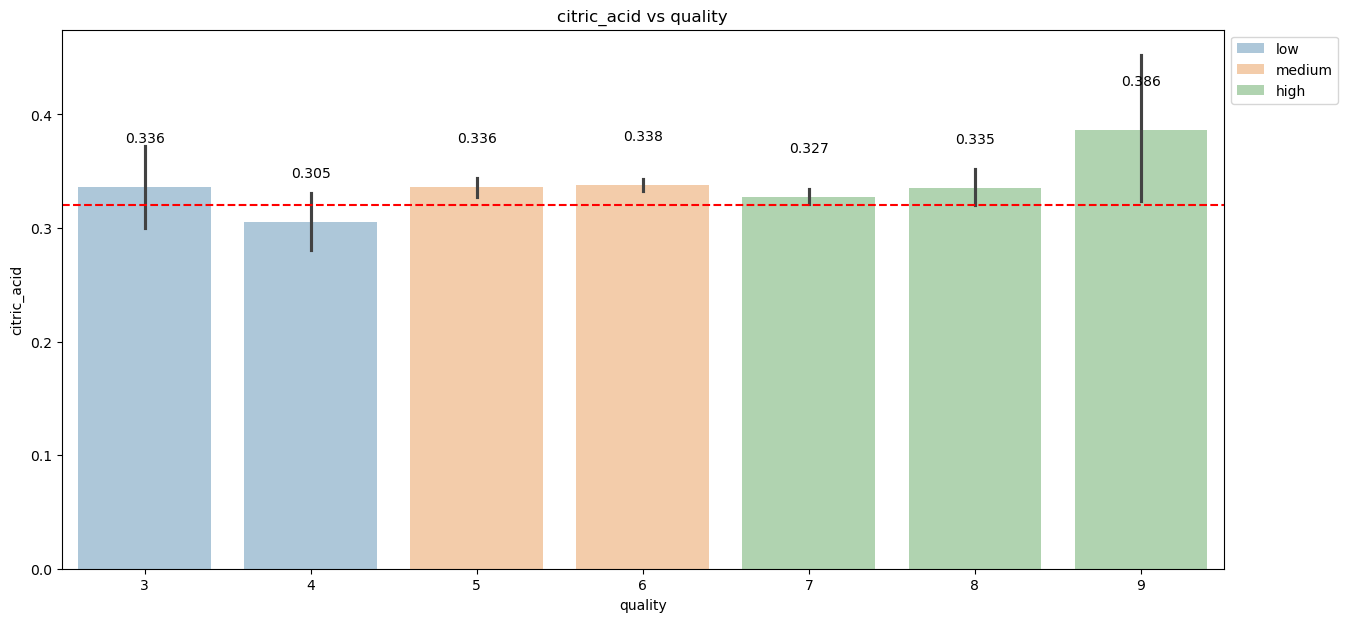

In [44]:
# fixed acidity , volatile acide, citric acid, quality
quality_predictor('citric_acid', 30)

* There seems to be no noticeable effect of citric acid content on the quality of white wines. 

Broken red line (Median value): 3.18


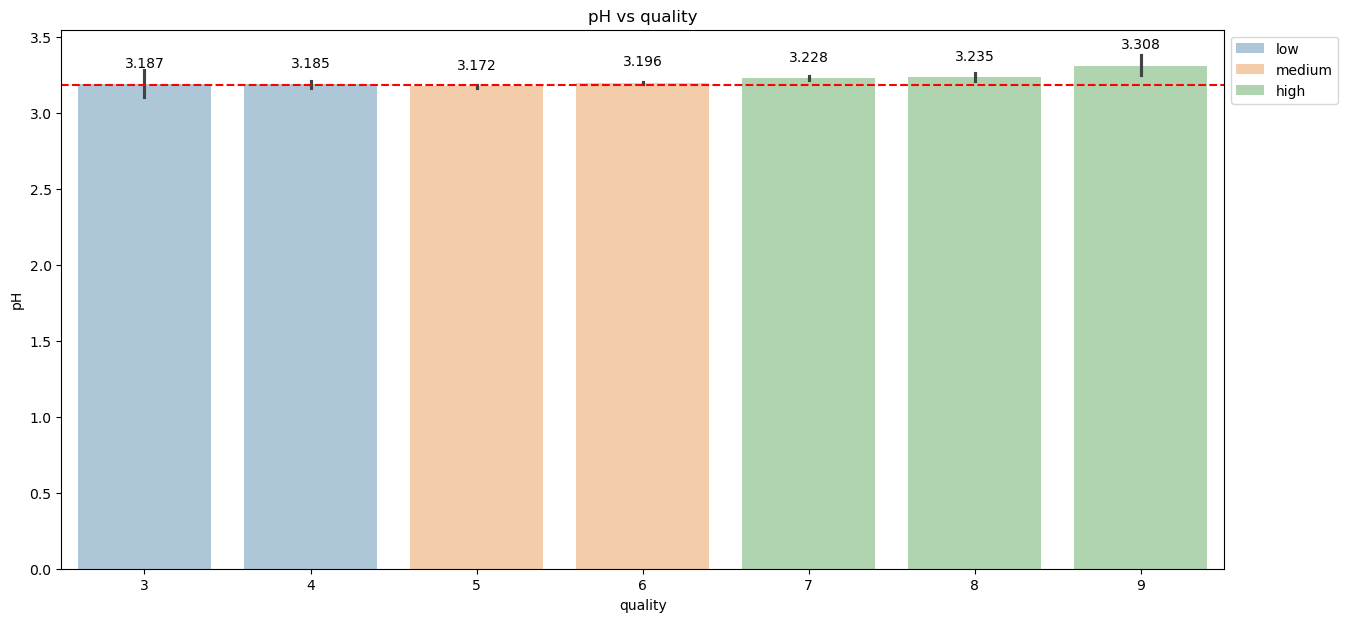

In [45]:
# pH vs quality
quality_predictor('pH', 10)

* There seems to be no noticeable effect of pH level on the quality of white wines. 

Note: Add in feature selection, total acids = volatile_acidity, fixed_acidity, citric_acid. 

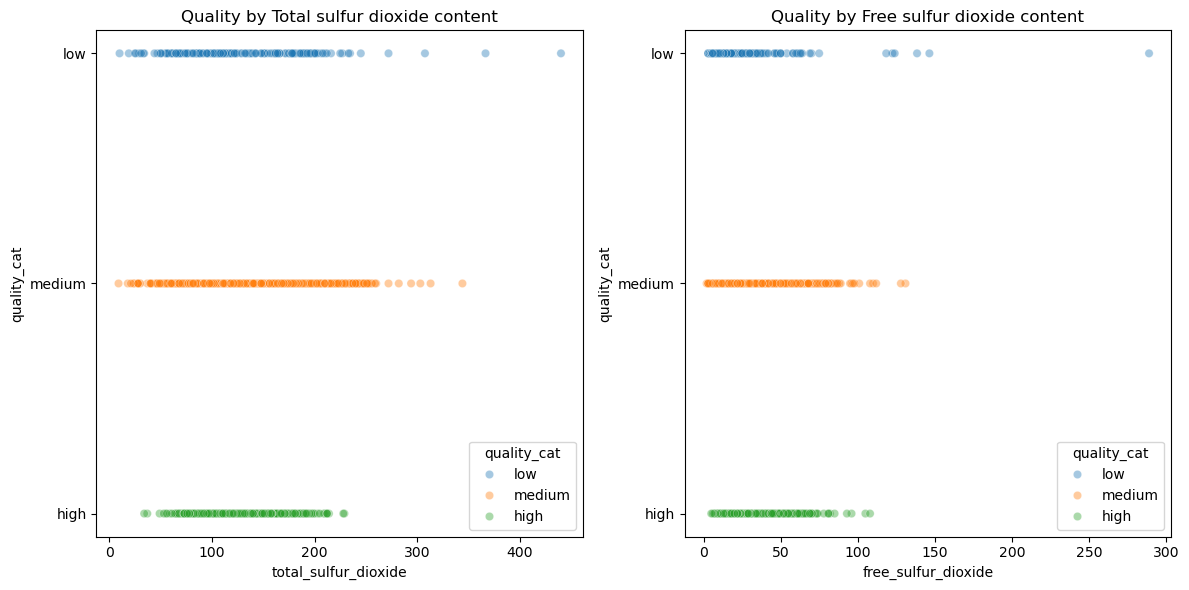

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
sns.scatterplot(data=df, x='total_sulfur_dioxide', y='quality_cat', 
                hue='quality_cat', alpha=0.4, ax=axes[0])
axes[0].set_title('Quality by Total sulfur dioxide content')

sns.scatterplot(data=df, x='free_sulfur_dioxide', y='quality_cat', 
                hue='quality_cat',alpha=0.4, ax=axes[1])
axes[1].set_title('Quality by Free sulfur dioxide content')
plt.tight_layout()
plt.show()

* High-quality wines appear to have lower `total_sulfur_dioxide` content, which is below $250$ $mg$/$dm^3$, the upper limit in the EU.
* Wines that have `free_sulfur_dioxide` content of greater than $110$ $mg$/$dm^3$ are either medium or low-quality wines.
* `free_sulfur_dioxide` and `total_sulfur_dioxide` are good predictors of wine quality.  

### Insights from Exploratory Data Analysis:
* Use this information in deciding which the data preprocessing steps to be used:
    * Most features do not follow a normal distribution
    * Outliers are present

* The good predictors of wine quality are the following:
    1. `alcohol`: High-quality wine seems to have higher alcohol content, while low-quality wines have lower alcohol content.
    2. `density`: Seems to have some correlation with residual sugar and alcohol content. Sweeter wines have higher density, while more alcoholic wines have lower density.
    3. `volatile_acidity`: Low-quality wine has a volatile acidity value higher than the median value.
    4. `chlorides`: High-quality wines have noticeably lower chloride content.
    5. `free_sulfur_dioxide` and `total_sulfur_dioxide`: High-quality wines appear to have lower `total_sulfur_dioxide` content, which is below $250$ $mg$/$dm^3$, the upper limit in the EU, while wines that have `free_sulfur_dioxide` content of greater than $110$ $mg$/$dm^3$ are either medium or low-quality wines.

# **paCe: Construct Stage**
* Determine which models are most appropriate
* Construct the model
* Confirm model assumptions
* Evaluate model results to determine how well your model fits the data

## Step 3. Model Building

### Things to consider before modeling: 

#### Identify the type of prediction task and the types of model most appropriate to be used
This task involves classifying data into three categories, making it a multi-class classification problem with imbalanced classes. The suitable models to build include logistic regression, KNearest Neighbors, Support Vector Machine, Random Forest, and XGBoost classifiers. To enhance the model's performance, consider the use of data preprocessing techniques such as Feature Engineering, Principal Component Analysis (PCA), and Synthetic Minority Oversampling Technique (SMOTE). 

#### Model selection process: using **Nested Cross-validation**

Since the wine dataset is not very large, it would be most appropriate to split the data only into two sets, the train and test sets. Also, in order to get an idea of how the final model will perform on future unseen data, it is important that the test set will only be used using the champion model. 

![see diagram](nested_cv_diagram.png)  

* Nested cross-validation involves multiple splits of the data into training, validation, and test sets.
* In the inner loop (*using the training set from the outer loop*), a model is fitted to each training set to approximately maximize the evaluation score, and then hyperparameters are optimized based on the validation set.
* In the outer loop, the model's performance is assessed by averaging the test set scores across various data splits.

Why choose model selection with nested cross-validation? 
> Model selection without nested cross-validation uses the same data to tune model parameters and evaluate model performance. Information may thus "leak" into the model and overfit the data. To avoid this, a nested cross-validation will be used in this project.[^6]

[^6]: Nested versus non-nested cross-validation. Scikit-learn. https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html 


#### Modeling Workflow
1. Split the data into train and test sets (80/20).
2. Execute the nested cross-validation using the original train set.
3. Select the champion model based on its performance on the outer loop of the nested cross-validation.
4. Get the best parameters of the champion model using GridSearchCV and train the champion model using the entire train set.
5. Assess the champion model's performance on the test set.


#### Identify the evaluation metrics to evaluate the models
* **F1 score** will be used to evaluate the performance of the selection of models.
* F1 score is the balance between precision (*minimizes false positive*) and recall (*minimizes false negative*).  
* F1 score is the most appropriate metric to use given that the dataset is imbalanced because the f1 score takes into account the type of errors&mdash;false positive and false negative, not just the number of predictions that were incorrect.
* For a multi-class classification problem, f1 score is calculated per class in a one-vs-the-rest manner. In this approach, each class's success is rated separately, as if there are distinct classifiers for each class.
* A high f1 score means the model is able to classify positive instances of a class accurately while minimizing false positives and false negatives.
* `macro`, `micro`, `weighted`
  
Please REVISE THIS: Note that in **macro averaging**, all classes get equal weight when contributing their portion of the precision value to the total. This might not be a realistic calculation when you have a large amount of class imbalance. In that case, a **weighted** average might make more sense.

#### Model assumptions

#### Logistic regression model assumptions
- [x] Outcome variable is categorical
- [x] Observations are independent of each other
- [x] No severe multicollinearity among X variables
- [x] No extreme outliers
- [x] Linear relationship between each X variable and the logit of the outcome variable
- [x] Sufficiently large sample size

#### Other assumptions: 
-  Other models such as K-nearest neighbors and support vector machines are much more sensitive to attributes with skewed distributions or outliers.
-  Some models, notably support vector machines, are sensitive to irrelevant attributes.

#### Preprocessing

In [47]:
# Label encode the quality_class
df = df.copy()  # To eliminate the SettingWithCopyWarning
df['quality_cat_code'] = df['quality_cat'].astype('category').cat.set_categories(
    ['low', 'medium', 'high']).cat.codes

df['quality_cat_code'].value_counts(normalize=True)

quality_cat_code
1    0.748043
2    0.208281
0    0.043676
Name: proportion, dtype: float64

### Modeling Round 1: Baseline&ndash;Including all the features

In [48]:
# Split the data into train and test sets 
X = df.drop(columns=['quality', 'quality_cat', 'quality_cat_code'], axis=1)
y = df['quality_cat_code']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=42)

# Check the split
for x in [X_train, X_test, y_train, y_test]: 
    print(len(x))

3168
793
3168
793


In [49]:
# Check the predictors
X.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [50]:
# Initialize the algorithm
logreg = LogisticRegression(multi_class='multinomial', random_state=42)
knn = KNeighborsClassifier(algorithm='ball_tree')
svm = SVC(random_state=42, probability=True)
xgb = XGBClassifier(objective='multi:softmax', random_state=42)
rf = RandomForestClassifier(random_state=42)

In [51]:
# Build pipelines for data preprocessing
pipe_logreg = Pipeline([('scaler', StandardScaler()),
                        ('logreg', logreg)])

pipe_knn = Pipeline([('scaler', StandardScaler()),
                     ('knn', knn)])

pipe_svm = Pipeline([('scaler', StandardScaler()),
                     ('svm', svm)])

# Get the parameter to be used in parameter grids
pipe_svm.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('svm', SVC(probability=True, random_state=42))],
 'verbose': False,
 'scaler': StandardScaler(),
 'svm': SVC(probability=True, random_state=42),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'svm__C': 1.0,
 'svm__break_ties': False,
 'svm__cache_size': 200,
 'svm__class_weight': None,
 'svm__coef0': 0.0,
 'svm__decision_function_shape': 'ovr',
 'svm__degree': 3,
 'svm__gamma': 'scale',
 'svm__kernel': 'rbf',
 'svm__max_iter': -1,
 'svm__probability': True,
 'svm__random_state': 42,
 'svm__shrinking': True,
 'svm__tol': 0.001,
 'svm__verbose': False}

In [52]:
# Set up hyperparameters
param_grid_logreg = [{'logreg__solver': ['newton-cg', 'lbfgs'],
                      'logreg__penalty': ['l2'],
                      'logreg__max_iter': [300, 500],
                      'logreg__C': np.power(10., np.arange(-4,4))}]

param_grid_knn = [{'knn__leaf_size': list(range(25,51)),
                   'knn__n_neighbors': list(range(3,30,2)),
                   'knn__p': [1,2]}]


param_grid_svm = [{'svm__kernel': ['linear', 'rbf'],
                   'svm__gamma': ['scale', 'auto'],
                   'svm__C': np.power(10., np.arange(-1,2))}]

param_grid_xgb = [{'max_depth': [3, 5, 9],
                   'min_child_weight': [1, 3, 5],
                   'subsample': [0.8],
                   'colsample_bytree': [0.8], 
                   'learning_rate': [0.01, 0.1],
                   'num_class': [3],
                   'n_estimators': [100, 300]}]

param_grid_rf = [{'max_depth': [6, 9, 12],
                  'max_features': [1.0],
                  'max_samples': [0.7, 1.0],
                  'min_samples_leaf': [1, 3, 5],
                  'min_samples_split': [2, 4, 6],
                  'n_estimators': [100, 300, 500]}]

In [53]:
# Set Scoring
scoring=['balanced_accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

##### Setting up the helper functions for inner and outer loop: 

In [54]:
def inner_looper(param_grid, algorithm, algo_name:str):
    '''
    Input: 
        param_grid: list of parameters for each algorithm
        algorithm:  list of algorithm
        algo_name:  list of algorithm names in string format

    Output: 
        gridcv:    dictionary with key as the algorithm name and values of GridSeach objects
    '''
    gridcv = {}
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # StratifiedKFold: Maintains class distribution across folds.

    for pgrid, est, name in zip((param_grid),
                                (algorithm),
                                (algo_name)):
        gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       scoring=scoring,
                       n_jobs=-1,
                       cv=inner_cv,
                       error_score='raise',
                       refit='f1_weighted')
        gridcv[name] = gcv

    return gridcv

In [55]:
def outer_looper(X_train_data, y_train_data, gridcv): 
    '''
    Input: 
        X_train_data: numpy array of the X_train
        y_train_data: numpy array of the y_train
        gridcv:       the inner loop function
    '''
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for name, gs_est in sorted(gridcv.items()):
        scores_dict = cross_validate(gs_est, 
                                     X=X_train_data,
                                     y=y_train_data, 
                                     scoring=scoring,
                                     cv=outer_cv,
                                     return_estimator=True,
                                     error_score='raise',
                                     n_jobs=-1)

        print(50 * '-', '\n')
        print('Algorithm:', name)
        print('     Inner loop:')


        for i in range(scores_dict['test_f1_weighted'].shape[0]):    
            print('\n         Best F1: (avg. of inner test folds) %.2f%%' % (scores_dict['estimator'][i].best_score_ * 100))
            print('         Best parameters:', scores_dict['estimator'][i].best_estimator_)
            print('         F1: (on outer test fold) %.2f%%' % (scores_dict['test_f1_weighted'][i]*100))
    
        print('\n%s | outer F1: %.2f%% +/- %.2f' %
              (name, scores_dict['test_f1_weighted'].mean() * 100,
               scores_dict['test_f1_weighted'].std() * 100))
    
        print('\nSUMMARY OF OUTER SCORES:')
        print(pd.DataFrame({'model': [name],
                            'precision': [scores_dict['test_precision_weighted'].mean()],
                            'recall': [scores_dict['test_recall_weighted'].mean()],
                            'F1': [scores_dict['test_f1_weighted'].mean()],
                            'accuracy': [scores_dict['test_balanced_accuracy'].mean()]
                           }))

In [68]:
# Run the nested cross-validation
outer_looper(X_train_data=X_train, y_train_data=y_train, gridcv=inner_looper(param_grid=[param_grid_logreg, param_grid_knn, param_grid_svm, param_grid_xgb, param_grid_rf],
                                                                             algorithm=[pipe_logreg, pipe_knn, pipe_svm, xgb, rf],
                                                                             algo_name=['LogReg', 'KNN', 'SVM', 'XGBoost', 'RForest']))

-------------------------------------------------- 

Algorithm: KNN
     Inner loop:

         Best F1: (avg. of inner test folds) 73.66%
         Best parameters: Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=25))])
         F1: (on outer test fold) 76.30%

         Best F1: (avg. of inner test folds) 75.36%
         Best parameters: Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=25,
                                      n_neighbors=9))])
         F1: (on outer test fold) 74.79%

         Best F1: (avg. of inner test folds) 73.88%
         Best parameters: Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=25,
                                      n_neighbors=19, p=1))])
         F1: (on outer test fold) 73.05%

* The f1 score of the XGBoost model is the highest. This indicates that the XGBoost model outperforms the other models.

In [56]:
# use pickle to save the fitted models
path = 'pickled_models'

In [57]:
# function to write the pickle
def write_pickle(path, model_object, save_as:str):
    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [58]:
def read_pickle(path, saved_model_name:str):
    with open(path + saved_model_name + '.pickle', 'rb') as to_read: 
        model = pickle.load(to_read)
    return model

In [59]:
# Helper function to use the entire training set for final model training to leverage all available data.
def champion_gcv(est, param_grid):
    champion_model = GridSearchCV(estimator=est,
                                  param_grid=param_grid,
                                  scoring=scoring,
                                  n_jobs=-1,
                                  cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                  verbose=1,
                                  error_score='raise',
                                  refit='f1_weighted')
    return champion_model

In [60]:
# Train the champion model on the entire training set
champion_model = champion_gcv(xgb, param_grid_xgb)

In [75]:
%%time
champion_model.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
CPU times: total: 5.02 s
Wall time: 1min 3s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy...
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='multi:softmax', ...),
             n_jobs=-1,
             param_grid=[{'colsample_bytree': [0.8],
                          'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 9],
                          'min_child_weight': [1, 3, 5],
                          'n_estimators': [100, 300], 'num_class': [3],
                          'subsample': [0.8]}],
             refit='f1_weighted',
             scoring=['balanced_accuracy', 'precision_weighted',
                      'recall_weighted', 'f1_weighted'],
             verbose=1)

In [76]:
# Save the model
write_pickle(path, champion_model, 'champion_model_round1')

In [60]:
# Read the pickle
champion_model = read_pickle(path, 'champion_model_round1')

In [61]:
champion_model.best_score_

0.7624796706406716

In [62]:
champion_model.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 9,
 'min_child_weight': 1,
 'n_estimators': 300,
 'num_class': 3,
 'subsample': 0.8}

In [63]:
def make_results(model_name:str, model_object, metric:str, modeling_round:str):
    '''
    Arguments: 
        model_name (string): what you want the model to be called in the output table
        model_object       : a fit GridSearchCV object
        metric (string)    : precision, recall, f1, accuracy, or roc_auc

    Return a pandas dataframe with the precision, recall, f1, accuracy, and roc_auc scores
    for the model with the best mean 'metric' score across all validation folds
    '''
    # Create a dictionary that maps input metric to actual metric name in the GridSearchCV
    metric_dict = {'precision': 'mean_test_precision_weighted',
                   'recall': 'mean_test_recall_weighted',
                   'f1': 'mean_test_f1_weighted', 
                   'accuracy': 'mean_test_balanced_accuracy'}
    
    # Get all the results from the CV and put them in a dataframe
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the dataframe with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(),:]
    
    # Extract precision, recall, f1, accuracy, roc_auc scores from that row
    precision = best_estimator_results.mean_test_precision_weighted
    recall = best_estimator_results.mean_test_recall_weighted
    f1 = best_estimator_results.mean_test_f1_weighted
    accuracy = best_estimator_results.mean_test_balanced_accuracy

    # Create table of results
    table = pd.DataFrame({'modeling_round': [modeling_round],
                          'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy]
                         })
    
    return table

In [64]:
def get_scores(model_name:str, model, X_test_data, y_test_data, modeling_round:str): 
    '''
    Generates a table of test scores.

    Arguments: 
        model_name (string): How you want your model to be named in the output table 
        model:               A fit GridSearchCV object
        X_test_data:         numpy array of X_test_data
        y_test_data:         numpy array of y_test_data

    Return: pandas DataFrame of precision, recall, f1, accuracy, and roc_auc scores 
    '''

    preds = model.best_estimator_.predict(X_test_data)

    precision = precision_score(y_test_data, preds, average='weighted')
    recall = recall_score(y_test_data, preds, average='weighted')
    f1 = f1_score(y_test_data, preds, average='weighted')
    accuracy = balanced_accuracy_score(y_test_data, preds)


   # Create table of results
    table = pd.DataFrame({'modeling_round': [modeling_round],
                          'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy]
                         })
    
    return table

In [65]:
# Assess the performance of the model during validation
champion_model_results = make_results('Champion_1 val', champion_model, 'f1', 'Baseline: All features')

# Assess the performance of the model using the test set
champion_model_test_scores = get_scores('Champion_1 test', champion_model, X_test, y_test, 'Baseline: All features')

# Summarize the results
results = pd.concat([champion_model_results, champion_model_test_scores], axis=0)
results

,modeling_round,model,precision,recall,f1,accuracy
0,Baseline: All features,Champion_1 val,0.762259,0.785353,0.76248,0.490853
0,Baseline: All features,Champion_1 test,0.780649,0.796974,0.77784,0.516711


* The test scores are quite similar to the validation scores, which is good. XGBoost model appears to be a strong model to predict wine quality. 

In [66]:
# Helper function to create a confusion matrix function
def confusion_matrix_displayer(model_name, X_test_data, y_test_data, matrix_name:str):
    '''
    Input: 
        champion_model:        model_object
        X_test_data:           numpy array of X_test_data
        y_test_data:           numpy array of y_test_data
        matrix_name (string):  how you want you confusion matrix to be named
    '''
    test_preds = model_name.best_estimator_.predict(X_test_data)
    labels = ['low', 'medium', 'high']

    cm = confusion_matrix(y_test_data, test_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Reds')
    plt.title(f'{matrix_name}')
    plt.savefig(f'{matrix_name}.png')
    plt.show()

In [67]:
# Function to print classification report
from sklearn.metrics import classification_report
def make_class_report(model, X_test_data, y_test_data):
    target_names = ['low', 'medium', 'high']
    label_names = [0, 1, 2]
    test_preds = model.best_estimator_.predict(X_test_data)
    print(classification_report(y_test_data, test_preds, labels=label_names, target_names=target_names))

In [68]:
# Helper function to plot the important features using XGBoost model
def importance_plotter(model, feature_name:str):
    ax = plot_importance(model.best_estimator_, importance_type='total_gain',  values_format="{v:.2f}")
    ax.set_title(f'{feature_name}')
    ax.figure.tight_layout()
    ax.figure.savefig(f'{feature_name}.png')
    plt.show()

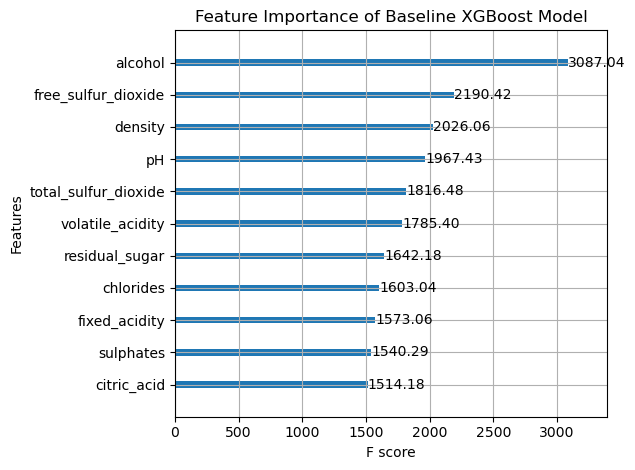

In [71]:
# Plot feature importance to reveal the strong predictors of the target variable
importance_plotter(champion_model, 'Feature Importance of Baseline XGBoost Model')

* The top 5 predictors of wine quality: `alcohol`, `free_sulfur_dioxide`, `density`, `pH`, and `total_sulfur_dioxide`.

### Modeling Round 2: Using Feature Engineering

#### Feature Engineering

In [72]:
# Adding new features
df2 = df.copy()

In [73]:
df2['total_acids'] = df2['fixed_acidity'] + df2['volatile_acidity'] + df2['citric_acid']
df2['total_acids_pH_ratio'] = df2['total_acids'] / df2['pH']
df2['resid_sugar_alc_ratio'] = df2['residual_sugar'] / df2['alcohol']

In [74]:
df2.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,quality_cat_code,total_acids,total_acids_pH_ratio,resid_sugar_alc_ratio
count,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000
mean,6.839346,0.280538,0.334332,5.914819,0.045905,34.889169,137.193512,0.993790,3.195458,0.490351,10.589358,5.854835,1.164605,7.454216,2.343864,0.587617
std,0.866860,0.103437,0.122446,4.861646,0.023103,17.210021,43.129065,0.002905,0.151546,0.113523,1.217076,0.890683,0.474256,0.912701,0.350815,0.516597
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000,4.130000,1.101333,0.056604
25%,6.300000,0.210000,0.270000,1.600000,0.035000,23.000000,106.000000,0.991620,3.090000,0.410000,9.500000,5.000000,1.000000,6.860000,2.115016,0.150794
50%,6.800000,0.260000,0.320000,4.700000,0.042000,33.000000,133.000000,0.993500,3.180000,0.480000,10.400000,6.000000,1.000000,7.370000,2.312303,0.423077
75%,7.300000,0.330000,0.390000,8.900000,0.050000,45.000000,166.000000,0.995710,3.290000,0.550000,11.400000,6.000000,1.000000,7.970000,2.544343,0.875000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000,2.000000,14.960000,4.749206,5.623932


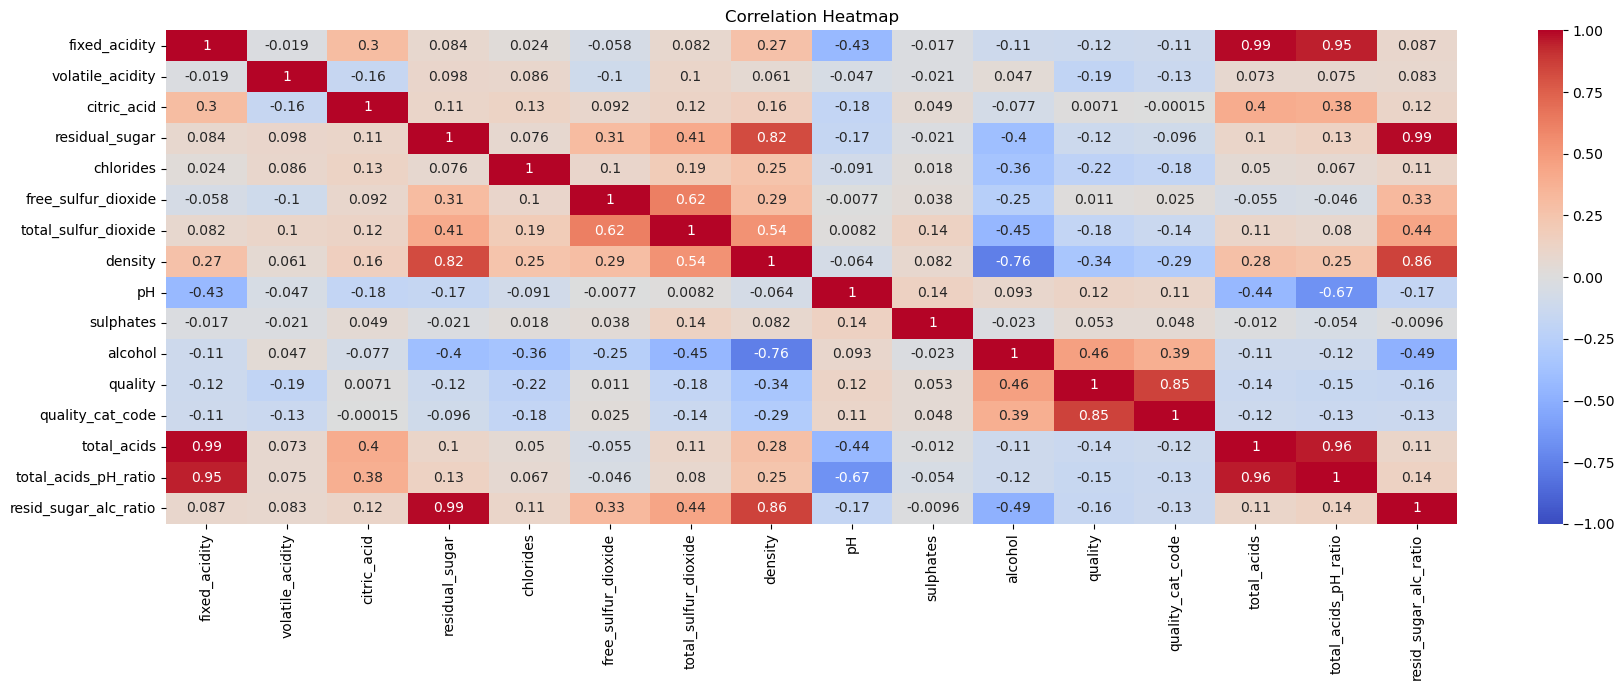

In [75]:
# Plot a correlation heatmap
plt.figure(figsize=(18,7))
fig = sns.heatmap(df2.corr(method='pearson', numeric_only=True), vmin=-1,
                 vmax=1, annot=True, cmap='coolwarm')
fig.set_title('Correlation Heatmap')
plt.tight_layout()
plt.savefig('corrmap2.png')
plt.show()

**Highly correlated features:**     
1. `fixed_acidity`, `total_acids` and `total_acids_pH_ratio` are highly correlated, choose `total_acids_pH_ratio` only. 
2. `residual_sugar`, `resid_sugar_alc_ratio` and `density`are highly correlated, keep `resid_sugar_alc_ratio`.

In [76]:
# Feature selection
X2 = df2.drop(columns=['quality', 'total_acids', 'quality_cat', 'quality_cat_code', 'fixed_acidity', 'density', 'residual_sugar'], axis=1) 
y2 = df2['quality_cat_code']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2,
                                                   stratify=y2, random_state=1)

# Check the train/test sets
for x in [X2_train, X2_test, y2_train, y2_test]:
    print(len(x))

# Inspect the variables
X2.head()

3168
793
3168
793


,volatile_acidity,citric_acid,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,pH,sulphates,alcohol,total_acids_pH_ratio,resid_sugar_alc_ratio
0,0.27,0.36,0.045,45.0,170.0,3.00,0.45,8.8,2.543333,2.352273
1,0.30,0.34,0.049,14.0,132.0,3.30,0.49,9.5,2.103030,0.168421
2,0.28,0.40,0.050,30.0,97.0,3.26,0.44,10.1,2.693252,0.683168
3,0.23,0.32,0.058,47.0,186.0,3.19,0.40,9.9,2.429467,0.858586
6,0.32,0.16,0.045,30.0,136.0,3.18,0.47,9.6,2.100629,0.729167


##### Using the same initialization, param grids, scoring as modeling round 1, run the nested cv for round 2: 

In [74]:
# Run the nested cross-validation 
outer_looper(X_train_data=X2_train, y_train_data=y2_train, gridcv=inner_looper(param_grid=[param_grid_logreg, param_grid_knn, param_grid_svm, param_grid_xgb, param_grid_rf],
                                                                               algorithm=[pipe_logreg, pipe_knn, pipe_svm, xgb, rf],
                                                                               algo_name=['LogReg', 'KNN', 'SVM', 'XGBoost', 'RForest']))

-------------------------------------------------- 

Algorithm: KNN
     Inner loop:

         Best F1: (avg. of inner test folds) 75.40%
         Best parameters: Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=25,
                                      p=1))])
         F1: (on outer test fold) 75.11%

         Best F1: (avg. of inner test folds) 73.81%
         Best parameters: Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=25,
                                      n_neighbors=13, p=1))])
         F1: (on outer test fold) 76.27%

         Best F1: (avg. of inner test folds) 75.23%
         Best parameters: Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=25))])
         F1: (on outer test fold) 72.92%

        

* The f1 score of the XGBoost model is the highest. This indicates that the XGBoost model outperforms the other models.

In [75]:
# Get the best hyperparameters of the champion model
champion_model2 = champion_gcv(xgb, param_grid_xgb)

In [76]:
%%time
champion_model2.fit(X2_train, y2_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
CPU times: total: 2.55 s
Wall time: 58.8 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy...
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='multi:softmax', ...),
             n_jobs=-1,
             param_grid=[{'colsample_bytree': [0.8],
                          'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 9],
                          'min_child_weight': [1, 3, 5],
                          'n_estimators': [100, 300], 'num_class': [3],
                          'subsample': [0.8]}],
             refit='f1_weighted',
             scoring=['balanced_accuracy', 'precision_weighted',
                      'recall_weighted', 'f1_weighted'],
             verbose=1)

In [77]:
# Save the model
write_pickle(path, champion_model2, 'champion_model_round2')

In [77]:
# Read the pickle
champion_model2 = read_pickle(path, 'champion_model_round2')

In [78]:
champion_model2.best_score_

0.7712660142894396

In [79]:
# Assess the performance of the model during validation
champion_model_results2 = make_results('Champion_2 val', champion_model2, 'f1', 'With Feature Engineering')

# Assess the performance of the model using the # using X=X1_test,y=y1_test
champion_model_test_scores2 = get_scores('Champion_2 test', champion_model2, X2_test, y2_test, 'With Feature Engineering')

# Summarize the results
results = pd.concat([results, champion_model_results2, champion_model_test_scores2], axis=0)
results

,modeling_round,model,precision,recall,f1,accuracy
0,Baseline: All features,Champion_1 val,0.762259,0.785353,0.762480,0.490853
0,Baseline: All features,Champion_1 test,0.780649,0.796974,0.777840,0.516711
0,With Feature Engineering,Champion_2 val,0.776331,0.792928,0.771266,0.501605
0,With Feature Engineering,Champion_2 test,0.750776,0.776797,0.752879,0.479801


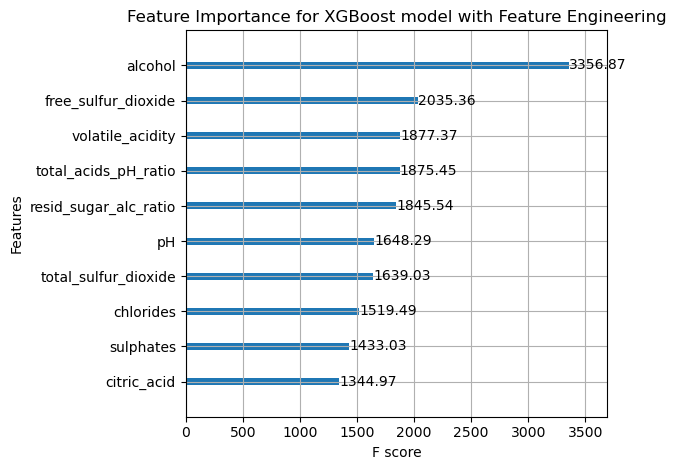

In [80]:
# Plot feature importance to reveal the strong predictors of the target variable
importance_plotter(champion_model2, 'Feature Importance for XGBoost model with Feature Engineering')

* The top 5 predictors of wine quality: `alcohol`, `free_sulfur_dioxide`, `volatile_acidity`, `total_acids_pH_ratio`, and `resid_sugar_alc_ratio`.

### Modeling Round 3: Addressing the class imbalance using SMOTE (Synthetic Minority Over-sampling Technique)
**NOTE:**
* Apply SMOTE only in training data but not the validation or test data: When using cross-validation, do not SMOTE the data before sending it in to the nested cross-validation process.  

In [81]:
df3 = df.copy()
# Feature selection
X3 = df3.drop(columns=['quality', 'quality_cat', 'quality_cat_code'], axis=1) 
y3 = df3['quality_cat_code']
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2,
                                                   stratify=y3, random_state=7)

# Check the train/test sets
for x in [X3_train, X3_test, y3_train, y3_test]:
    print(len(x))

# Inspect the variables
X3_train.head()

3168
793
3168
793


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
1690,9.0,0.43,0.30,1.50,0.050,7.0,175.0,0.99510,3.11,0.45,9.7
3485,7.5,0.21,0.32,4.80,0.056,39.0,113.0,0.99393,3.11,0.52,10.2
3393,8.0,0.28,0.30,8.40,0.030,35.0,115.0,0.99192,2.93,0.42,12.3
582,7.3,0.30,0.22,6.40,0.056,44.0,168.0,0.99470,3.13,0.35,10.1
3355,5.3,0.32,0.23,9.65,0.026,26.0,119.0,0.99168,3.18,0.53,12.2


In [82]:
# Build pipelines for data preprocessing
pipe_logreg = imbpipeline(steps = [('scale', StandardScaler()),
                                   ('over', SMOTE(random_state=42)),
                                   ('logreg', logreg)])


pipe_knn = imbpipeline(steps = [('scale', StandardScaler()),
                                ('over', SMOTE(random_state=42)),
                                ('knn', knn)])

pipe_svm = imbpipeline(steps = [('scale', StandardScaler()),
                                ('over', SMOTE(random_state=42)),
                                ('svm', svm)])

pipe_xgb = imbpipeline(steps = [('over', SMOTE(random_state=42)),
                                ('xgb', xgb)])

pipe_rf = imbpipeline(steps = [('over', SMOTE(random_state=42)),
                               ('rf', rf)])

In [83]:
# Set up the parameter grids for hyperparameter tuning
param_grid_logreg = [{'logreg__solver': ['newton-cg', 'lbfgs'],
                      'logreg__penalty': ['l2'],
                      'logreg__max_iter': [300, 500],
                      'logreg__C': np.power(10., np.arange(-4, 4))}]

param_grid_knn = [{'knn__leaf_size': list(range(25,51)),
                   'knn__n_neighbors': list(range(3, 30,2)),
                   'knn__p': [1, 2]}]

param_grid_svm = [{'svm__kernel': ['linear', 'rbf'],
                   'svm__gamma': ['scale', 'auto'],
                   'svm__C': np.power(10., np.arange(-1, 2))}]

param_grid_xgb = [{'xgb__max_depth': [3, 5, 9], 
                   'xgb__min_child_weight': [1, 3, 5],
                   'xgb__subsample': [0.8],
                   'xgb__colsample_bytree': [0.8],
                   'xgb__learning_rate': [0.01, 0.1],
                   'xgb__num_class': [3],
                   'xgb__n_estimators': [100, 300]}]

param_grid_rf = [{'rf__max_depth': [6, 9, 12], 
                  'rf__max_features': [1.0],
                  'rf__max_samples': [0.7, 1.0],
                  'rf__min_samples_leaf': [1, 3, 5],
                  'rf__min_samples_split': [2, 4, 6],
                  'rf__n_estimators': [100, 300, 500]}]

#### Using the same initialization and scoring, run the nested cross-validation for round 3:

In [109]:
# Run the nested cross-validation 
outer_looper(X_train_data=X3_train, y_train_data=y3_train, gridcv=inner_looper(param_grid=[param_grid_logreg, param_grid_knn, param_grid_svm, param_grid_xgb, param_grid_rf],
                                                                               algorithm=[pipe_logreg, pipe_knn, pipe_svm, pipe_xgb, pipe_rf],
                                                                               algo_name=['LogReg', 'KNN', 'SVM', 'XGBoost', 'RForest']))

-------------------------------------------------- 

Algorithm: KNN
     Inner loop:

         Best F1: (avg. of inner test folds) 64.00%
         Best parameters: Pipeline(steps=[('scale', StandardScaler()), ('over', SMOTE(random_state=42)),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=25,
                                      n_neighbors=3, p=1))])
         F1: (on outer test fold) 65.88%

         Best F1: (avg. of inner test folds) 64.97%
         Best parameters: Pipeline(steps=[('scale', StandardScaler()), ('over', SMOTE(random_state=42)),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=25,
                                      n_neighbors=3, p=1))])
         F1: (on outer test fold) 67.59%

         Best F1: (avg. of inner test folds) 64.42%
         Best parameters: Pipeline(steps=[('scale', StandardScaler()), ('over', SMOTE(random_state=42)),
                ('knn',
               

* The f1 score of the XGBoost model is the highest. This indicates that the XGBoost model outperforms the other models.

In [110]:
# Get the best hyperparameters of the champion model
champion_model3 = champion_gcv(pipe_xgb, param_grid_xgb)

In [111]:
%%time
champion_model3.fit(X3_train, y3_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
CPU times: total: 9.38 s
Wall time: 2min


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise',
             estimator=Pipeline(steps=[('over', SMOTE(random_state=42)),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eva...
                                                      objective='multi:softmax', ...))]),
             n_jobs=-1,
             param_grid=[{'xgb__colsample_bytree': [0.8],
                          'xgb__learning_rate': [0.01, 0.1],
                          'xgb__max_depth': [3, 5, 9],
                          'xgb__min_child_weight': [1, 3, 5],
                          'xgb__n_estimators': [100, 300],
                          'xgb__num_class': [3], 'xgb__subsample': [0.8]}],
             refit='f1_weighted',
             scoring=['balanced_accuracy', 'precision_weighted',
                      'recall_weighted', 'f1_weighted'],
             verbose=1)

In [112]:
# Save the model
write_pickle(path, champion_model3, 'champion_model_round3')

In [84]:
# Read the pickle
champion_model3 = read_pickle(path, 'champion_model_round3')

In [85]:
champion_model3.best_score_

0.7647139155333414

In [86]:
champion_model3.best_params_

{'xgb__colsample_bytree': 0.8,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 9,
 'xgb__min_child_weight': 1,
 'xgb__n_estimators': 300,
 'xgb__num_class': 3,
 'xgb__subsample': 0.8}

In [87]:
# Assesss the performance of the model during validation
champion_model_results3 = make_results('Champion_3 val', champion_model3, 'f1', 'With SMOTE')

# Assess the performance of the model using X2_test, y2_test
champion_model_test_scores3 = get_scores('Champion_3 test', champion_model3, X3_test, y3_test, 'With SMOTE')

# Summarize the results
results = pd.concat([results, champion_model_results3, champion_model_test_scores3], axis=0)
results

,modeling_round,model,precision,recall,f1,accuracy
0,Baseline: All features,Champion_1 val,0.762259,0.785353,0.762480,0.490853
0,Baseline: All features,Champion_1 test,0.780649,0.796974,0.777840,0.516711
0,With Feature Engineering,Champion_2 val,0.776331,0.792928,0.771266,0.501605
0,With Feature Engineering,Champion_2 test,0.750776,0.776797,0.752879,0.479801
0,With SMOTE,Champion_3 val,0.762146,0.768308,0.764714,0.575687
0,With SMOTE,Champion_3 test,0.764850,0.774275,0.768106,0.558692


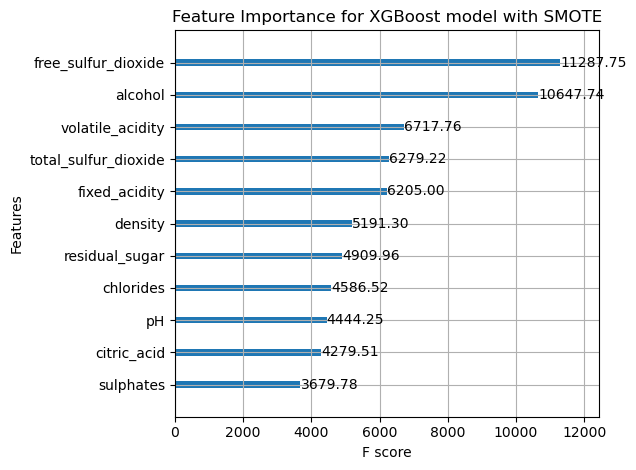

In [88]:
# Plot the feature importance from pipeline
champion_xgb_pipeline = champion_model3.best_estimator_
xgb_model = champion_xgb_pipeline.named_steps['xgb']
ax = plot_importance(xgb_model, importance_type='total_gain', values_format="{v:.2f}")
ax.set_title('Feature Importance for XGBoost model with SMOTE')
ax.figure.tight_layout()
ax.figure.savefig('Feature Importance for XGBoost model with SMOTE.png')
plt.show()

* The top 5 predictors of wine quality: `free_sulfur_dioxide`, `alcohol`, `volatile_acidity`, `total_acids_pH_ratio`, and `fixed_acidity`.

#### Comparing the feature importance of the XGBoost model to the Random Forest model

In [344]:
# Get the best hyperparameters of the champion model
champion_model_rf = champion_gcv(pipe_rf, param_grid_rf)

In [123]:
%%time
champion_model_rf.fit(X3_train, y3_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
CPU times: total: 1min 11s
Wall time: 43min 25s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise',
             estimator=Pipeline(steps=[('over', SMOTE(random_state=42)),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'rf__max_depth': [6, 9, 12],
                          'rf__max_features': [1.0],
                          'rf__max_samples': [0.7, 1.0],
                          'rf__min_samples_leaf': [1, 3, 5],
                          'rf__min_samples_split': [2, 4, 6],
                          'rf__n_estimators': [100, 300, 500]}],
             refit='f1_weighted',
             scoring=['balanced_accuracy', 'precision_weighted',
                      'recall_weighted', 'f1_weighted'],
             verbose=1)

In [124]:
# Save the model
write_pickle(path, champion_model_rf, 'champion_model_rf')

In [89]:
# Read the pickle
champion_model_rf = read_pickle(path, 'champion_model_rf')

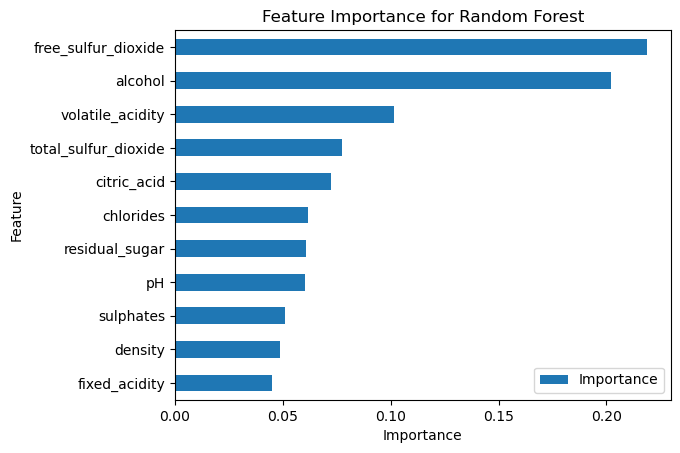

In [90]:
# Get the feature importances for random forest
champion_rf_pipeline = champion_model_rf.best_estimator_
feat_import = champion_rf_pipeline.named_steps['rf'].feature_importances_

# Get the indices of the features
indices = np.argpartition(feat_import,-11)[-11:]

# Get the column labels
feature_names = X3.columns[indices]

y_df = pd.DataFrame({'Feature': feature_names, 'Importance': feat_import})
y_sort_df = y_df.sort_values('Importance')
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh', ax=ax1, x='Feature', y='Importance')

ax1.set_title('Feature Importance for Random Forest', fontsize=12)
ax1.set_ylabel('Feature')
ax1.set_xlabel('Importance')

plt.savefig('Feature Importance for Random Forest.png')
plt.show()

 * Having the same top 3 features, the feature importance plot of the Random Forest Model confirms the top 3 most important features of the XGBoost model: `free_sulfur_dioxide`, `alcohol`, and `volatile_acidity`

### Modeling Round 3.b: Using the variables from feature engineering in Modeling Round 2&ndash;With feature engineering and SMOTE
This additional modeling round was only done to compute the evaluation results when the features from Modeling Round 2 were used together with SMOTE. As it turned out, the f1 scores are lower than with just using the original features together with SMOTE. **It is still recommended to use the original features.**

In [91]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2,
                                                   stratify=y2, random_state=2)

# Check the train sets
print(X2_train.columns)
print(y2_train.value_counts())

Index(['volatile_acidity', 'citric_acid', 'chlorides', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'pH', 'sulphates', 'alcohol',
       'total_acids_pH_ratio', 'resid_sugar_alc_ratio'],
      dtype='object')
quality_cat_code
1    2370
2     660
0     138
Name: count, dtype: int64


Using the same initialization, scoring, pipeline, parameters as modeling round 3 run the nested cross-validation for round 3.a:

In [105]:
# Run the nested cross-validation
outer_looper(X_train_data=X2_train, y_train_data=y2_train, gridcv=inner_looper(param_grid=[param_grid_logreg, param_grid_knn, param_grid_svm, param_grid_xgb],
                                                                               algorithm=[pipe_logreg, pipe_knn, pipe_svm, pipe_xgb],
                                                                               algo_name=['LogReg', 'KNN', 'SVM', 'XGBoost']))

-------------------------------------------------- 

Algorithm: KNN
     Inner loop:

         Best F1: (avg. of inner test folds) 67.95%
         Best parameters: Pipeline(steps=[('scale', StandardScaler()), ('over', SMOTE(random_state=42)),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=25,
                                      n_neighbors=3, p=1))])
         F1: (on outer test fold) 64.98%

         Best F1: (avg. of inner test folds) 65.52%
         Best parameters: Pipeline(steps=[('scale', StandardScaler()), ('over', SMOTE(random_state=42)),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=25,
                                      n_neighbors=3, p=1))])
         F1: (on outer test fold) 69.42%

         Best F1: (avg. of inner test folds) 66.34%
         Best parameters: Pipeline(steps=[('scale', StandardScaler()), ('over', SMOTE(random_state=42)),
                ('knn',
               

### Modeling Round 4: Principal Component Analysis

In [92]:
# Initialize the algorithm
logreg = LogisticRegression(multi_class='multinomial', random_state=42)
knn = KNeighborsClassifier(algorithm='ball_tree')
svm = SVC(random_state=42, probability=True)
xgb = XGBClassifier(objective='multi:softmax', random_state=42, importance_type='total_gain')
rf = RandomForestClassifier(random_state=42)

Note: **Total gain** shows the total improvement brought by a feature to make accurate predictions in the training data.

In [93]:
df4 = df.copy()

In [94]:
# Split the data into train and test sets 
X4 = df4.drop(columns=['quality', 'quality_cat', 'quality_cat_code'], axis=1)
y4 = df4['quality_cat_code']
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, 
                                                    stratify=y4, random_state=22)

# Check the split
for x in [X4_train, X4_test, y4_train, y4_test]: 
    print(len(x))

3168
793
3168
793


#### Determining the number of components to be used in PCA:

In [95]:
scaler = StandardScaler()
scaler.fit(X4)

StandardScaler()

In [96]:
scaled_data = scaler.transform(X4)

In [97]:
from sklearn.decomposition import PCA

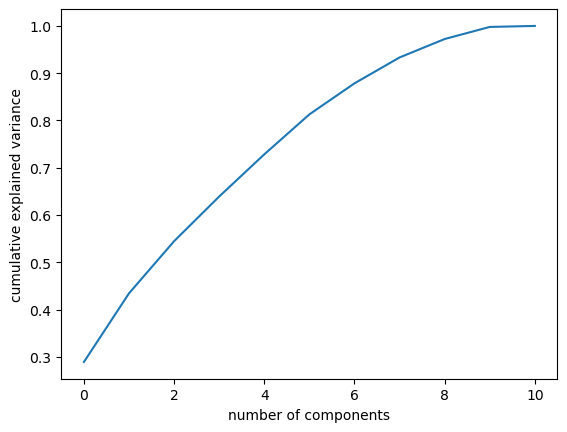

In [98]:
pca = PCA().fit(scaled_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [99]:
# Set n_components to 0.95 for 95% explained variance
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(scaled_data)

print(f'Number of components chosen to explain 95% variance: {pca.n_components_}')

Number of components chosen to explain 95% variance: 9


In [100]:
pca = PCA(n_components=0.95)

In [101]:
# Build pipelines for data preprocessing
pipe_logreg = Pipeline(steps = [('scale', StandardScaler()),
                                ('pca', pca),
                                ('logreg', logreg)])

pipe_knn = Pipeline(steps = [('scale', StandardScaler()),
                             ('pca', pca),
                             ('knn', knn)])

pipe_svm = Pipeline(steps = [('scale', StandardScaler()),
                             ('pca', pca),
                             ('svm', svm)])

pipe_xgb = Pipeline(steps = [('scale', StandardScaler()),
                             ('pca', pca),
                             ('xgb', xgb)])

In [102]:
# Set up the parameter grids for hyperparameter tuning
param_grid_logreg = [{'logreg__solver': ['newton-cg', 'lbfgs'],
                      'logreg__penalty': ['l2'],
                      'logreg__max_iter': [300, 500],
                      'logreg__C': np.power(10., np.arange(-4, 4))}]

param_grid_knn = [{'knn__leaf_size': list(range(25,51)),
                   'knn__n_neighbors': list(range(3, 30,2)),
                   'knn__p': [1, 2]}]
                   
param_grid_svm = [{'svm__kernel': ['linear', 'rbf'],
                   'svm__gamma': ['scale', 'auto'],
                   'svm__C': np.power(10., np.arange(-1, 2))}]
                   

param_grid_xgb = [{'xgb__max_depth': [3, 5, 9], 
                   'xgb__min_child_weight': [1, 3, 5],
                   'xgb__subsample': [0.8],
                   'xgb__colsample_bytree': [0.8],
                   'xgb__learning_rate': [0.01, 0.1],
                   'xgb__num_class': [3],
                   'xgb__n_estimators': [100, 300]}]   

In [257]:
# Run the nested cross-validation 
outer_looper(X_train_data=X4_train, y_train_data=y4_train, gridcv=inner_looper(param_grid=[param_grid_logreg, param_grid_knn, param_grid_svm, param_grid_xgb],
                                                                               algorithm=[pipe_logreg, pipe_knn, pipe_svm, pipe_xgb],
                                                                               algo_name=['LogReg', 'KNN', 'SVM', 'XGBoost']))

-------------------------------------------------- 

Algorithm: KNN
     Inner loop:

         Best F1: (avg. of inner test folds) 74.09%
         Best parameters: Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=25))])
         F1: (on outer test fold) 72.35%

         Best F1: (avg. of inner test folds) 73.43%
         Best parameters: Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=25))])
         F1: (on outer test fold) 73.22%

         Best F1: (avg. of inner test folds) 73.63%
         Best parameters: Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=25,
                                      n_neighbors=29))])
  

* The f1 score of the Support Vector Classifier is the highest. This indicates that the SVM model outperforms the other models.

In [258]:
champion_model4 = champion_gcv(pipe_svm, param_grid_svm)

In [259]:
%%time
champion_model4.fit(X4_train, y4_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
CPU times: total: 4.16 s
Wall time: 1min 36s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise',
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('pca', PCA(n_components=0.95)),
                                       ('svm',
                                        SVC(probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid=[{'svm__C': array([ 0.1,  1. , 10. ]),
                          'svm__gamma': ['scale', 'auto'],
                          'svm__kernel': ['linear', 'rbf']}],
             refit='f1_weighted',
             scoring=['balanced_accuracy', 'precision_weighted',
                      'recall_weighted', 'f1_weighted'],
             verbose=1)

In [260]:
# Save the model
write_pickle(path, champion_model4, 'champion_model_round4')

In [103]:
# Read the pickle
champion_model4 = read_pickle(path, 'champion_model_round4')

In [104]:
champion_model4.best_params_

{'svm__C': 10.0, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}

In [105]:
# Assess the performance of the model during validation 
champion_model_results4 = make_results('Champion_4 val', champion_model4, 'f1', 'With PCA')

# Assess the performance of the model using the test set
champion_model_test_scores4 = get_scores('Champion_4 test', champion_model4, X4_test, y4_test, 'With PCA')

results = pd.concat([results, champion_model_results4, champion_model_test_scores4], axis=0)
results

,modeling_round,model,precision,recall,f1,accuracy
0,Baseline: All features,Champion_1 val,0.762259,0.785353,0.762480,0.490853
0,Baseline: All features,Champion_1 test,0.780649,0.796974,0.777840,0.516711
0,With Feature Engineering,Champion_2 val,0.776331,0.792928,0.771266,0.501605
0,With Feature Engineering,Champion_2 test,0.750776,0.776797,0.752879,0.479801
0,With SMOTE,Champion_3 val,0.762146,0.768308,0.764714,0.575687
0,With SMOTE,Champion_3 test,0.764850,0.774275,0.768106,0.558692
0,With PCA,Champion_4 val,0.741907,0.770833,0.740807,0.463754
0,With PCA,Champion_4 test,0.772247,0.790668,0.765861,0.522044


In [106]:
# Plot the feature importance from pipeline
from sklearn.inspection import permutation_importance
pipeline_svm = champion_model4.best_estimator_

In [107]:
# Get the PCA-transformed features
X4_pca = pipeline_svm.named_steps['pca'].transform(pipeline_svm.named_steps['scale'].transform(X4))

In [108]:
# Compute the permutation feature importance
permutation_results = permutation_importance(pipeline_svm.named_steps['svm'], X4_pca, y4, n_repeats=10, random_state=42)

In [109]:
# Map the importance scores back to the original features
pca_components = pipeline_svm.named_steps['pca'].components_
importances = np.abs(np.dot(permutation_results.importances_mean, pca_components))

# Sort the importances in descending order
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_feature_names = np.array(X4.columns)[sorted_indices]

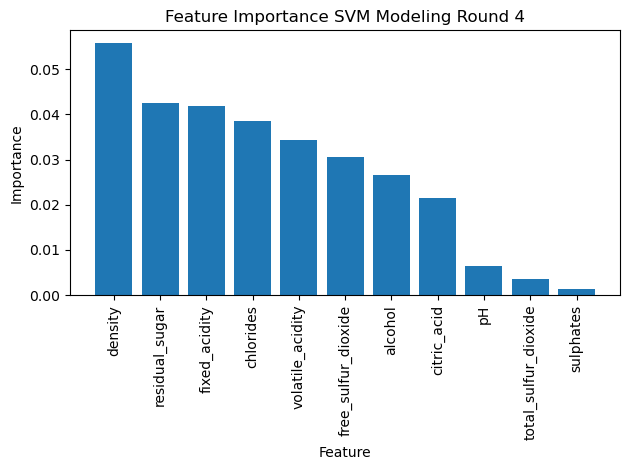

In [110]:
# Plot the feature importances
plt.figure(figure=(15,8))
plt.bar(range(len(sorted_importances)), sorted_importances, align='center')
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importance SVM Modeling Round 4')
plt.tight_layout()
plt.savefig('Feature Importance SVM Modeling Round 4')
plt.show()

### Modeling Round 5: Using SMOTE and PCA

In [111]:
# split the data into train and test sets
df5 = df.copy()
X5 = df5.drop(columns=['quality', 'quality_cat', 'quality_cat_code'], axis=1)
y5 = df5['quality_cat_code']

X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.20,
                                                       stratify=y5, random_state=24)

# Check 
for x in [X5_train, X5_test, y5_train, y5_test]: 
    print(len(x))

# Check train and sets
print(X5_train.columns)
print(y5_train.value_counts())

3168
793
3168
793
Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')
quality_cat_code
1    2370
2     660
0     138
Name: count, dtype: int64


In [112]:
# Additional 
scale = StandardScaler()
over = SMOTE(random_state=42)
pca = PCA(n_components=0.95)

In [113]:
# Build pipelines for data preprocessing
pipe_logreg = imbpipeline(steps = [('scale', scale), ('over', over),
                                   ('pca', pca), ('logreg', logreg)])


pipe_knn = imbpipeline(steps = [('scale', scale), ('over', over),
                                ('pca', pca), ('knn', knn)])

pipe_svm = imbpipeline(steps = [('scale', scale), ('over', over),
                                ('pca', pca), ('svm', svm)])

pipe_xgb = imbpipeline(steps = [('scale', scale), ('over', over),
                                ('pca', pca), ('xgb', xgb)])

In [114]:
# Set up the parameter grids for hyperparameter tuning
param_grid_logreg = [{'logreg__solver': ['newton-cg', 'lbfgs'],
                      'logreg__penalty': ['l2'],
                      'logreg__max_iter': [300, 500],
                      'logreg__C': np.power(10., np.arange(-4, 4))}]

param_grid_knn = [{'knn__leaf_size': list(range(25,51)),
                   'knn__n_neighbors': list(range(3, 30,2)),
                   'knn__p': [1, 2]}]
                   
param_grid_svm = [{'svm__kernel': ['linear', 'rbf'],
                   'svm__gamma': ['scale', 'auto'],
                   'svm__C': np.power(10., np.arange(-1, 2))}]
                   

param_grid_xgb = [{'xgb__max_depth': [3, 5, 9], 
                   'xgb__min_child_weight': [1, 3, 5],
                   'xgb__subsample': [0.8],
                   'xgb__colsample_bytree': [0.8],
                   'xgb__learning_rate': [0.01, 0.1],
                   'xgb__num_class': [3],
                   'xgb__n_estimators': [100, 300]}]   

In [278]:
# Run the nested cross-validation 
outer_looper(X_train_data=X5_train, y_train_data=y5_train, gridcv=inner_looper(param_grid=[param_grid_logreg, param_grid_knn, param_grid_svm, param_grid_xgb],
                                                                               algorithm=[pipe_logreg, pipe_knn, pipe_svm, pipe_xgb],
                                                                               algo_name=['LogReg', 'KNN', 'SVM', 'XGBoost']))

-------------------------------------------------- 

Algorithm: KNN
     Inner loop:

         Best F1: (avg. of inner test folds) 65.81%
         Best parameters: Pipeline(steps=[('scale', StandardScaler()), ('over', SMOTE(random_state=42)),
                ('pca', PCA(n_components=0.95)),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=25,
                                      n_neighbors=3))])
         F1: (on outer test fold) 64.62%

         Best F1: (avg. of inner test folds) 64.60%
         Best parameters: Pipeline(steps=[('scale', StandardScaler()), ('over', SMOTE(random_state=42)),
                ('pca', PCA(n_components=0.95)),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=25,
                                      n_neighbors=3, p=1))])
         F1: (on outer test fold) 66.63%

         Best F1: (avg. of inner test folds) 64.68%
         Best parameters: Pipeline(steps=[('scale',

In [279]:
champion_model5 = champion_gcv(pipe_xgb, param_grid_xgb)

In [280]:
%%time
champion_model5.fit(X5_train, y5_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
CPU times: total: 11.2 s
Wall time: 4min 14s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise',
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('over', SMOTE(random_state=42)),
                                       ('pca', PCA(n_components=0.95)),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=No...
                                                      objective='multi:softmax', ...))]),
             n_jobs=-1,
             param_grid=[{'xgb__colsample_bytree': [0.8],
                          'xgb__learning_rate': [0.01, 0.1],
                          'xgb__max_depth': [3, 5, 9],
                          'xgb__min_child_weight': [1, 3, 5],
                          'xgb__n_estimators': [100, 300],
                          'xgb__num_class': [3], 'xgb__subsample': [0.8]}],
             refit='f1_weighted',
             scoring=['balanced_accuracy', 'precision_weighted',
                      'recall_weighted', 'f1_weighted'],
             verbose=1)

In [281]:
# Write pickle
write_pickle(path, champion_model5, 'champion_model_round5')

In [115]:
# Read the pickle
champion_model5 = read_pickle(path, 'champion_model_round5')

In [116]:
champion_model5.best_params_

{'xgb__colsample_bytree': 0.8,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 9,
 'xgb__min_child_weight': 1,
 'xgb__n_estimators': 300,
 'xgb__num_class': 3,
 'xgb__subsample': 0.8}

In [117]:
# Assess the performance of the model during validation 
champion_model_results5 = make_results('Champion_5 val', champion_model5, 'f1', 'With SMOTE & PCA')

# Assess the performance of the model using the test set
champion_model_test_scores5 = get_scores('Champion_5 test', champion_model5, X5_test, y5_test, 'With SMOTE & PCA')

# Combine the results to the rest of the results
results = pd.concat([results, champion_model_results5, champion_model_test_scores5], axis=0)
results

,modeling_round,model,precision,recall,f1,accuracy
0,Baseline: All features,Champion_1 val,0.762259,0.785353,0.762480,0.490853
0,Baseline: All features,Champion_1 test,0.780649,0.796974,0.777840,0.516711
0,With Feature Engineering,Champion_2 val,0.776331,0.792928,0.771266,0.501605
0,With Feature Engineering,Champion_2 test,0.750776,0.776797,0.752879,0.479801
0,With SMOTE,Champion_3 val,0.762146,0.768308,0.764714,0.575687
0,With SMOTE,Champion_3 test,0.764850,0.774275,0.768106,0.558692
0,With PCA,Champion_4 val,0.741907,0.770833,0.740807,0.463754
0,With PCA,Champion_4 test,0.772247,0.790668,0.765861,0.522044
0,With SMOTE & PCA,Champion_5 val,0.751734,0.739266,0.744526,0.566970
0,With SMOTE & PCA,Champion_5 test,0.731931,0.709962,0.719466,0.510217


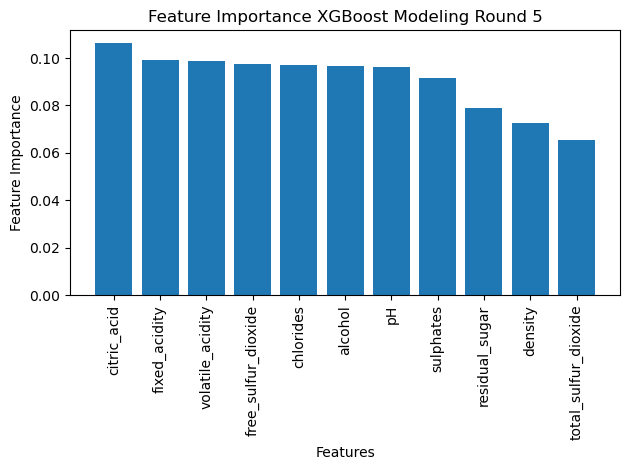

In [118]:
# Plot feature importance
pipeline_xgb = champion_model5.best_estimator_
xgb_classifier = pipeline_xgb.named_steps['xgb']

# Get feature importances
feature_importances = xgb_classifier.feature_importances_

# Map the importance scores back to the original features
components = pipeline_xgb.named_steps['pca'].components_
original_feature_importances = np.zeros(components.shape[1])
for i in range(len(feature_importances)):
    original_feature_importances += np.abs(components[i, :]) * feature_importances[i]

# Normalize to make the importances sum to 1
original_feature_importances /= np.sum(original_feature_importances)

# Sort the importances in descending order
sorted_indices = np.argsort(original_feature_importances)[::-1]
sorted_importances = original_feature_importances[sorted_indices]
sorted_feature_names = np.array(X5.columns)[sorted_indices]


# Plot the feature importances
plt.figure(figure=(15,8))
plt.bar(range(len(sorted_importances)), sorted_importances, align='center')
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=90)
plt.ylabel('Feature Importance')
plt.xlabel('Features')
plt.title('Feature Importance XGBoost Modeling Round 5')
plt.tight_layout()
plt.savefig('Feature Importance XGBoost Modeling Round 5.png')
plt.show()

* The features appear to have very close y-values, which is not effective in distinguishing the most important features.
* The feature importances of the PCA-transformed models are different from the models that do not use PCA.
    * Without PCA, feature importance directly relates to each feature's impact on the model.  
    * The difference in the feature importances might be because of the nature of PCA. PCA linearly transforms the original features into a new set of uncorrelated variables called principal components. Each principal component is a weighted sum of the original features, such that the first principal component captures the maximum variance in the data, the second captures the next highest variance orthogonal to the first, and so on. PCA aims to maximize the variance explained by the components rather than selecting features based on their direct predictive power on a target variable.

# **pacE: Execute Stage**
* Interpret model
* Evaluate model performance using metrics
* Prepare results, visualizations, and actionable steps to share with stakeholders

## Step 4. Results and Evaluation 

In [119]:
# Choosing between the Baseline model and the model with SMOTE
results

,modeling_round,model,precision,recall,f1,accuracy
0,Baseline: All features,Champion_1 val,0.762259,0.785353,0.762480,0.490853
0,Baseline: All features,Champion_1 test,0.780649,0.796974,0.777840,0.516711
0,With Feature Engineering,Champion_2 val,0.776331,0.792928,0.771266,0.501605
0,With Feature Engineering,Champion_2 test,0.750776,0.776797,0.752879,0.479801
0,With SMOTE,Champion_3 val,0.762146,0.768308,0.764714,0.575687
0,With SMOTE,Champion_3 test,0.764850,0.774275,0.768106,0.558692
0,With PCA,Champion_4 val,0.741907,0.770833,0.740807,0.463754
0,With PCA,Champion_4 test,0.772247,0.790668,0.765861,0.522044
0,With SMOTE & PCA,Champion_5 val,0.751734,0.739266,0.744526,0.566970
0,With SMOTE & PCA,Champion_5 test,0.731931,0.709962,0.719466,0.510217


* During model selection, the evaluation results of the baseline model are very close to the results of the model with SMOTE. Still, the baseline model scored higher during the prediction of the test set.
* However, the model with SMOTE has more consistent f1 score results during evaluation and testing. 

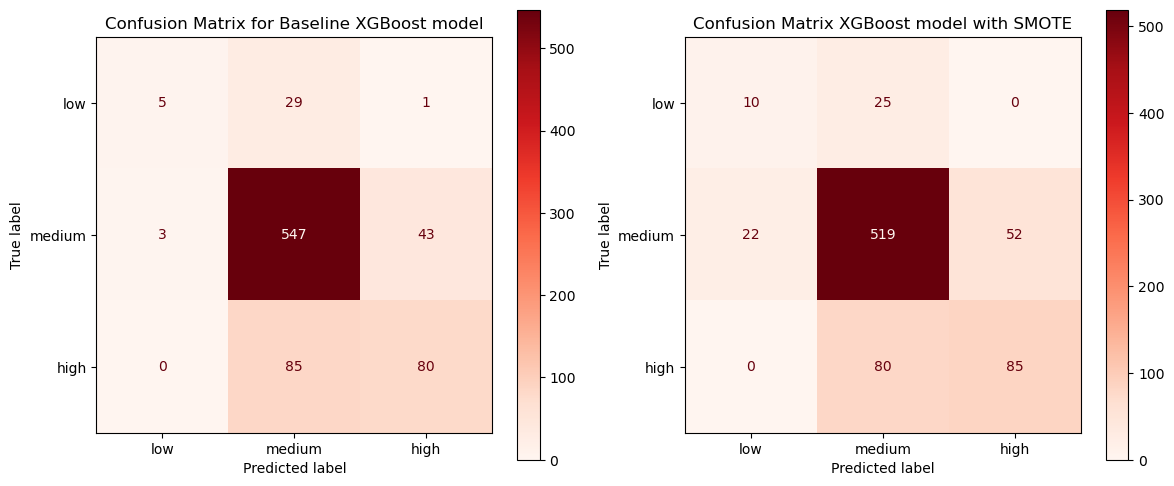

In [121]:
# Comparing the confusion matrices of the Baseline model and the model with SMOTE
labels = ['low', 'medium', 'high']

# Data for the baseline model 
y_true1 = y_test
y_pred1 = champion_model.best_estimator_.predict(X_test)

# Data for the model with SMOTE
y_true3 = y3_test
y_pred3 = champion_model3.best_estimator_.predict(X3_test)

# Confusion matrices
cm1 = confusion_matrix(y_true1, y_pred1)
cm2 = confusion_matrix(y_true3, y_pred3)

# Confusion matrix display
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=labels)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=labels)

# Plotting the two cms together
fig, ax = plt.subplots(1,2, figsize=(12,5))
disp1.plot(ax=ax[0], cmap='Reds')
ax[0].set_title('Confusion Matrix for Baseline XGBoost model')
disp2.plot(ax=ax[1], cmap='Reds')
ax[1].set_title('Confusion Matrix XGBoost model with SMOTE')

plt.tight_layout()
plt.show()



* Because of the class imbalance, the Baseline model is more effective in classifying medium-class wines, decreasing its ability to predict low and high-quality wine; a wine sample was even classified as high-quality when in reality, it is of low quality. 
    * From the confusion matrix of the baseline model, 92% of the medium-quality wines are correctly classified. However, only 14% of low-quality wines and 49% of high-quality wines were classified correctly.

* To eliminate the bias towards the majority class, oversampling was done to balance the classes in the training set using SMOTE.
    * From the confusion matrix for the model with SMOTE, 88% of the medium-quality wines are correctly classified. After SMOTE, 29% of low-quality wines and 52% of high-quality wines were classified correctly. Because of this, **the XGBoost combined with SMOTE will be used as the final model**.  

In [122]:
print(make_class_report(champion_model, X_test, y_test))
print(make_class_report(champion_model3, X3_test, y3_test))

              precision    recall  f1-score   support

         low       0.62      0.14      0.23        35
      medium       0.83      0.92      0.87       593
        high       0.65      0.48      0.55       165

    accuracy                           0.80       793
   macro avg       0.70      0.52      0.55       793
weighted avg       0.78      0.80      0.78       793

None
              precision    recall  f1-score   support

         low       0.31      0.29      0.30        35
      medium       0.83      0.88      0.85       593
        high       0.62      0.52      0.56       165

    accuracy                           0.77       793
   macro avg       0.59      0.56      0.57       793
weighted avg       0.76      0.77      0.77       793

None


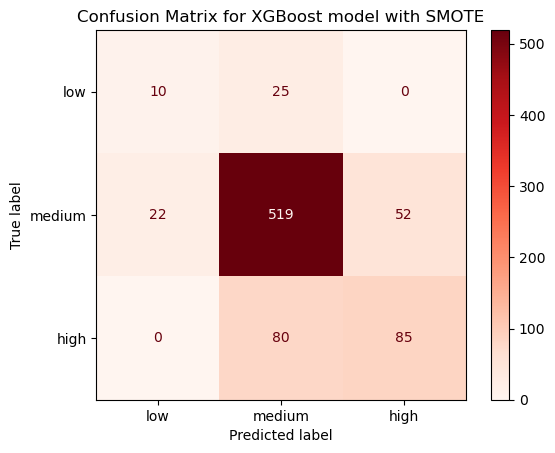

In [123]:
# Plot the confusion matrix
confusion_matrix_displayer(champion_model3, X3_test, y3_test, 'Confusion Matrix for XGBoost model with SMOTE')

* **Class:** `low`
    * The model correctly classified 10 out of 35 low-quality wines, about 29%.
    * It misclassified 25 poor-quality wines as medium-quality.
    * Crucially, no low-quality wine was classified as high-quality.
    * Overall, the model struggles the most with identifying low-quality wines, leading to low precision and recall, and an f1 score of ~30%.
 
* **Class:** `medium`
    * The model correctly classified 519 out of 593 medium-quality wines, about 88%.
    * It misclassified 22 medium-quality wines as low-quality and 52 as high-quality.
    * Overall, the model performs well in identifying medium-quality wines, with high precision and recall, and f1 score of 85%. 

* **Class:** `high`
    * The model correctly classified 85 out of 165 high-quality wines, 52%.
    * It misclassified 80 high-quality wines as medium-quality wines.
    * Crucially, no high-quality wine was classified as low-quality.
    * Overall, the model performs moderately well in identifying high-quality wines, with an f1 score of ~56%. 

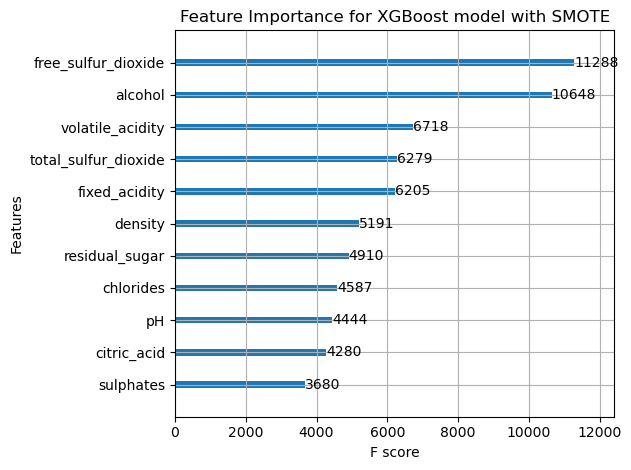

In [127]:
# Plot the feature importance
champion_xgb_pipeline = champion_model3.best_estimator_
xgb_model = champion_xgb_pipeline.named_steps['xgb']
ax = plot_importance(xgb_model, importance_type='total_gain', values_format="{v:1.0f}")
ax.set_title('Feature Importance for XGBoost model with SMOTE')
ax.figure.tight_layout()
ax.figure.savefig('Feature Importance for XGBoost model with SMOTE final.png')
plt.show()

* `free_sulfur_dioxide`, `alcohol`, `volatile_acidity`, `total_sulfur_dioxide`, and `fixed acidity`are the top 5 predictors of the quality of wine. 

### Summary of model results
* The XGBoost with SMOTE outperforms the other models. From the confusion matrix, the model accurately classifies 88% of medium-quality wines (519/593), struggles with low-quality wines (10/35, 29%), and moderately performs well with high-quality ones (85/165, 52%). It exhibits bias towards medium-quality wines, misclassifying 25 low-quality and 80 high-quality wines as medium-quality wines. Despite this, the model still performs reasonably well, with a weighted f1 score of 77%, making it useful in predicting wine quality.
  
  
* The feature importance graph confirms that key predictors identified during exploratory data analysis closely align with the top features. This confirms that `free sulfur dioxide`, `alcohol`, `volatile acidity`, and `total sulfur dioxide` are key factors in predicting wine quality. 

## **Conclusion and Recommendations**

* The modeling effort demonstrates that physicochemical indicators can reliably reflect white wine quality, thus serving as a useful tool for improving both quality evaluation and the wine itself.
  
* Integrate the model into a decision support system during wine tasting to improve the speed and consistency of quality evaluations. For instance, the experts could only repeat the tasting if their quality score was significantly different from the class predicted by the model.
  
* Improve the effectiveness of the model by adding new features such as grape variety or combination of grape varieties, color, phenolic compounds, and glycerol levels.
    * Color: Wine color is crucial in consumer sensory evaluation both before and after purchase, influencing perceived flavor and shaping expectations about the wine's style and quality.[^7]
    * Phenolic compounds: Phenolic compounds, though present in lower concentrations in white wines, significantly influence the wine’s sensory attributes, particularly the taste and aroma.[^8]
    * Glycerol levels: Glycerol, though typically low in white wine, enhances its viscosity and body. Wines with more glycerol were rated as superior.[^9]
 
* Share the findings of this project with wine manufacturers, particularly the variables that can be controlled during the production process such as alcohol content, volatile acidity, free sulfur dioxide levels and pH,  and residual sugars. 
 


 
[^7]: Parpinello, G.P., A. Versari, F. Chinnici, and S. Galassi. 2009. Relationship among sensory descriptors, consumer preference and color parameters of Italian Novello red wines. Food Research International 42:1389-1395.  
[^8]: Clarke, S., Bosman, G., du Toit, W., & Aleixandre‐Tudo, J. L. (2022). White wine phenolics: current methods of analysis. In Journal of the Science of Food and Agriculture (Vol. 103, Issue 1, pp. 7–25). Wiley. https://doi.org/10.1002/jsfa.12120  
[^9]: Amerine M.A. Composition of wines. I. Organic constituents. Adv. Food Res. 1954;5:353–510. doi: 10.1016/S0065-2628(08)60226-8. 
